# Graph Generation with GNNs

In this notebook, we explore **molecular graph generation** using the ZINC dataset, a widely-used benchmark for computational chemistry and drug discovery tasks. The primary objective is to **generate novel molecular structures** that are chemically valid, diverse, and potentially useful in practical applications such as drug design.  

To achieve this, we train and evaluate several state-of-the-art generative models specifically designed for graph-structured data:

## 1. GraphGAN
A generative adversarial network tailored for graphs, where a generator learns to produce molecular graphs while a discriminator evaluates their realism. This approach leverages the adversarial training paradigm to encourage high-quality and structurally plausible molecule generation.

## 2. GraphVAE
A variational autoencoder adapted for graph data, which encodes molecular graphs into a continuous latent space and decodes them back into valid molecular structures. GraphVAE provides a probabilistic framework, enabling smooth exploration of chemical space and interpolation between molecules.

## 3. DiGress Lite
A diffusion-based generative model for graphs that iteratively refines noisy graphs into chemically valid structures. DiGress Lite combines the benefits of diffusion models with computational efficiency, making it suitable for large-scale molecular generation tasks.

---

In the sections that follow, we will:

- Preprocess the ZINC dataset for graph-based learning.
- Train each of these models on molecular graphs.
- Evaluate their performance quantitatively and qualitatively.
- Compare their strengths and limitations for molecular design.

## Setup & Reproducibility

In [2]:
!pip install -q rdkit networkx torch torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# I. Graph GAN

In [3]:
# =========================
# Standard library
# =========================
import os
import math
import random
import itertools

# =========================
# Typing
# =========================
from typing import List, Tuple

# =========================
# Scientific computing
# =========================
import numpy as np
import networkx as nx

# =========================
# PyTorch
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import spectral_norm

# =========================
# PyTorch Geometric
# =========================
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from torch_geometric.datasets import ZINC

# =========================
# Scikit-learn
# =========================
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# RDKit
# =========================
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import Draw, Descriptors, AllChem, rdFMCS, rdFingerprintGenerator
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# =========================
# Reproducibility
# =========================
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# =========================
# Device
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# =========================
# RDKit Logging
# =========================
# Silence RDKit warnings (keep errors). Comment this out if you want full logs.
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.error')

Using device: cuda
PyTorch version: 2.6.0+cu124


## 2. Data Loading & Preprocessing

We use a subset of the **ZINC dataset** for molecular graph generation, consisting of **10,000 molecules**. Each molecule is represented as a graph, where:

- **Nodes** correspond to atoms.
- **Edges** correspond to chemical bonds.
- **Node features** encode atom-specific information.
- **Edge features** encode bond-specific information.

### Dataset Details

- **Dataset size:** 10,000 molecules  
- **Number of node features:** 1  
- **Number of edge features:** 1  

### Example Molecule

A sample molecule in the dataset has the following properties:

- **Number of nodes (atoms):** 29  
- **Number of edges (bonds):** 64  
- **Node features shape:** `torch.Size([29, 1])`  
- **Edge index shape:** `torch.Size([2, 64])`  
- **Edge features shape:** `torch.Size([64])`  
- **Target property shape:** `torch.Size([1])`  

Dataset size: 10000
Number of node features: 1
Number of edge features: 1
Sample molecule: Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])
Number of nodes: 29
Number of edges: 64
Node features shape: torch.Size([29, 1])
Edge index shape: torch.Size([2, 64])
Sample molecule visualization:


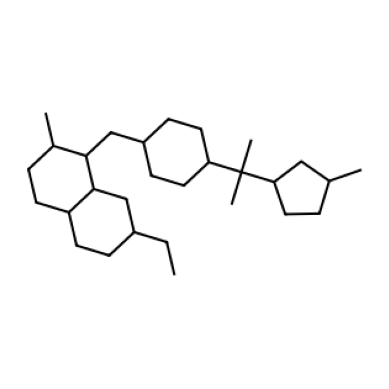

SMILES: CCC1CCC2CCC(C)C(CC3CCC(C(C)(C)C4CCC(C)C4)CC3)C2C1


In [ ]:
# Load ZINC dataset (subset for faster training)
dataset = ZINC(root='data/ZINC', subset=True, split='train')

# Small subset for demonstration
small_dataset = dataset[:10000]
print(f"Dataset size: {len(small_dataset)}")
print(f"Number of node features: {dataset.num_node_features}")
print(f"Number of edge features: {dataset.num_edge_features}")

# Convert node features to float
for data in small_dataset:
    data.x = data.x.float()

# Examine a sample molecule
sample_data = small_dataset[0]
print(f"Sample molecule: {sample_data}")
print(f"Number of nodes: {sample_data.num_nodes}")
print(f"Number of edges: {sample_data.num_edges}")
print(f"Node features shape: {sample_data.x.shape}")
print(f"Edge index shape: {sample_data.edge_index.shape}")

# Convert to RDKit molecule for visualization
def graph_to_mol(data):
    try:
        # Create empty molecule
        mol = Chem.RWMol()

        # Add atoms
        atom_types = {0: 'C', 1: 'N', 2: 'O', 3: 'F', 4: 'Cl', 5: 'Br', 6: 'I', 7: 'P', 8: 'S'}  # Extended mapping
        for i in range(data.x.shape[0]):
            atom_type_idx = torch.argmax(data.x[i]).item()
            if atom_type_idx in atom_types:
                atom = Chem.Atom(atom_types[atom_type_idx])
                mol.AddAtom(atom)

        # Add bonds (simplified)
        edge_index = data.edge_index.t().tolist()
        for i, (src, dst) in enumerate(edge_index):
            if src < dst:  # Avoid duplicates
                mol.AddBond(int(src), int(dst), Chem.BondType.SINGLE)

        # Convert to mol
        mol = mol.GetMol()
        Chem.SanitizeMol(mol)
        return mol
    except Exception as e:
        print(f"Error converting graph to molecule: {e}")
        return None

# Visualize a sample molecule
sample_mol = graph_to_mol(sample_data)
if sample_mol:
    print("Sample molecule visualization:")
    img = Draw.MolToImage(sample_mol)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(f"SMILES: {Chem.MolToSmiles(sample_mol)}")
else:
    print("Could not convert sample to molecule")

## 3. Utilities

To support graph-to-molecule conversion and enforce chemical validity, we define several **utility functions and constants** used throughout the notebook.

---

### Atom Vocabulary and Valence Constraints

We define the set of atom types used in the dataset and their approximate **maximum valences**. These are used to **prune edges** during molecule generation, ensuring chemically valid structures.

In [ ]:
# Atom vocab and approximate valences used to prune edges
ATOM_TYPES = ['C','N','O','F','Cl','Br','I','P','S']   # index -> atom symbol
MAX_VALENCE = {
    'H':1, 'C':4, 'N':3, 'O':2, 'F':1, 'Cl':1, 'Br':1, 'I':1, 'P':5, 'S':6
}
N_ATOM_TYPES = len(ATOM_TYPES)

# Generation sampling params
max_nodes = 38
GEN_THRESHOLD = 0.5
GEN_TEMPERATURE = 1.0
NODE_KEEP_CONF_THRESH = 0.15

In [ ]:
def graph_to_mol_safe(data):
    """
    Convert PyG Data with one-hot node features (N x T) and edge_index (2 x E)
    to RDKit molecule. Returns RDKit Mol or None if invalid/sanitization fails.
    """
    try:
        # node features must be one-hot or similar
        if data.x is None or data.x.shape[0] == 0:
            return None
        N = int(data.x.shape[0])

        atom_symbols = []
        # support numpy arrays and torch Tensors
        for i in range(N):
            row = data.x[i]
            if isinstance(row, torch.Tensor):
                arr = row.detach().cpu().numpy()
            else:
                arr = np.asarray(row)
            idx = int(np.argmax(arr))
            if idx < len(ATOM_TYPES):
                atom_symbols.append(ATOM_TYPES[idx])
            else:
                atom_symbols.append('C')

        mol = Chem.RWMol()
        for sym in atom_symbols:
            mol.AddAtom(Chem.Atom(sym))

        # build unique undirected edge set
        if data.edge_index is not None and data.edge_index.numel() > 0:
            ei = data.edge_index.cpu().numpy()
            pairs = set()
            for a,b in zip(ei[0].tolist(), ei[1].tolist()):
                if a == b:
                    continue
                u, v = int(a), int(b)
                if u > v:
                    u, v = v, u
                pairs.add((u, v))
            for (u, v) in pairs:
                if u < N and v < N:
                    try:
                        mol.AddBond(int(u), int(v), Chem.BondType.SINGLE)
                    except Exception:
                        # skip
                        continue

        mol = mol.GetMol()
        # Try sanitization with catch
        try:
            Chem.SanitizeMol(mol)
        except Exception:
            # return None for molecules RDKit cannot sanitize
            return None
        return mol
    except Exception as e:
        return None

## 4. GAN Model: Architecture

In this section, we describe the **Graph Generative Adversarial Network (GraphGAN)** used for molecular graph generation. The model consists of two main components: a **Generator** and a **Discriminator**, along with utility functions to convert logits into valid molecular graphs.

---

### 4.1. Generator

The **Generator** produces molecular graphs in two parts:

- **Node logits**: Probabilities over atom types for each node.  
- **Adjacency logits**: Probabilities of edges (bonds) between nodes.

#### Architecture

- **Input:** random noise vector representing latent features.  
- **Node MLP:** transforms the noise vector into node logits for each atom type.  
- **Adjacency MLP:** transforms the noise vector into adjacency logits representing potential edges.  
- **Post-processing:**  
  - Diagonal elements of the adjacency matrix are suppressed to prevent self-bonds.  
  - Adjacency matrix is symmetrized to ensure undirected edges.  

---

### 4.2. Discriminator

The **Discriminator** evaluates the realism of generated graphs by taking flattened representations of:

- Node features (soft one-hot vectors).  
- Adjacency matrices (soft edge probabilities).

#### Architecture

- **Input:** concatenation of node and adjacency representations.  
- Multi-layer perceptron with **spectral normalization** for training stability.  
- Outputs a single score per graph for adversarial training.

---

### 4.3. Differentiable Conversions

To train GraphGAN end-to-end, **soft differentiable representations** are used:

- Generator logits are converted to soft node and edge probabilities for differentiable training.  
- Real molecular graphs are converted to soft tensors for comparison by the discriminator.  
- Generated logits can be transformed into discrete graphs while respecting chemical valence rules.

---

### 4.4. Pros and Cons of GraphGAN

#### Pros

- Directly models **discrete molecular graphs** using node and adjacency logits.  
- Adversarial training encourages **realistic and diverse molecule generation**.  
- Flexible and extensible to larger graphs or additional atom/bond features.

#### Cons

- Training can be **unstable**, typical of GANs, especially with discrete graph data.  
- May produce **chemically invalid molecules** without post-processing.  
- Adversarial losses are **difficult to balance**, requiring careful tuning of hyperparameters.  
- Latent space is **less interpretable** compared to VAE-based models.

---

### 4.5. Summary

GraphGAN combines a **noise-to-graph generator** with a **graph discriminator** to learn the distribution of molecular graphs. Differentiable soft-tensor representations and valence-aware post-processing allow the model to generate chemically plausible molecules while training end-to-end with adversarial loss.


In [ ]:
class SimpleGenerator(nn.Module):
    def __init__(self, noise_dim, n_atom_types, max_nodes=38):
        super(SimpleGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.n_atom_types = n_atom_types
        self.max_nodes = max_nodes

        self.node_mlp = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_atom_types * max_nodes)
        )

        self.adj_mlp = nn.Sequential(
            nn.Linear(noise_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, max_nodes * max_nodes)
        )

    def forward(self, z):
        batch_size = z.size(0)
        node_logits = self.node_mlp(z).view(batch_size, self.max_nodes, self.n_atom_types)
        adj_logits = self.adj_mlp(z).view(batch_size, self.max_nodes, self.max_nodes)
        # zero diagonal strongly to avoid self-bonds
        diag_idx = torch.arange(self.max_nodes, device=z.device)
        adj_logits[:, diag_idx, diag_idx] = -10.0
        # symmetrize
        adj_logits = (adj_logits + adj_logits.permute(0,2,1)) / 2.0
        return node_logits, adj_logits

class SimpleDiscriminator(nn.Module):
    def __init__(self, n_atom_types, max_nodes=38, hidden_dim=512):
        super(SimpleDiscriminator, self).__init__()
        self.n_atom_types = n_atom_types
        self.max_nodes = max_nodes
        # Flattened size: nodes_soft (B, N, T) + adj_soft (B, N, N)
        input_dim = n_atom_types * max_nodes + max_nodes * max_nodes
        self.mlp = nn.Sequential(
            spectral_norm(nn.Linear(input_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(hidden_dim // 2, 1))
        )

    def forward(self, nodes_soft, adj_soft):
        # nodes_soft: (B, N, T) float
        # adj_soft:   (B, N, N) float
        if not torch.is_floating_point(nodes_soft): nodes_soft = nodes_soft.float()
        if not torch.is_floating_point(adj_soft):   adj_soft   = adj_soft.float()
        B = nodes_soft.size(0)
        x_flat  = nodes_soft.reshape(B, -1)
        a_flat  = adj_soft.reshape(B, -1)
        h = torch.cat([x_flat, a_flat], dim=1)
        return self.mlp(h).view(-1)   # hinge expects raw scores (no sigmoid)


# differentiable conversion for training (no numpy / no threshold)
def logits_to_soft_tensors(node_logits, adj_logits, temperature=1.0):
    """
    node_logits: (B, max_nodes, n_atom_types)
    adj_logits:  (B, max_nodes, max_nodes)
    Returns:
      nodes_soft: (B, max_nodes, n_atom_types)  -- soft one-hot (probabilities)
      adj_soft:   (B, max_nodes, max_nodes)     -- symmetric, diag=0, in [0,1]
    """
    nodes_soft = F.softmax(node_logits / temperature, dim=-1)            # differentiable
    adj_soft   = torch.sigmoid(adj_logits / temperature)                 # differentiable

    B, N, _ = node_logits.shape
    # zero diagonal & symmetrize (keep it differentiable)
    diag = torch.eye(N, device=adj_soft.device, dtype=torch.bool).unsqueeze(0)
    adj_soft = adj_soft.masked_fill(diag, 0.0)
    adj_soft = 0.5 * (adj_soft + adj_soft.transpose(1, 2))
    return nodes_soft, adj_soft

def real_batch_to_soft_tensors(batch, max_nodes=max_nodes, n_atom_types=N_ATOM_TYPES, device=device):
    """
    Convert a PyG batch to dense soft tensors for D:
      nodes_soft: (B, N, T) one-hot (float)
      adj_soft:   (B, N, N) {0,1} (float)
    """
    B = batch.num_graphs
    nodes = torch.zeros(B, max_nodes, n_atom_types, device=device)
    adj   = torch.zeros(B, max_nodes, max_nodes, device=device)

    for i in range(B):
        mask = (batch.batch == i)
        node_idx = torch.nonzero(mask, as_tuple=False).view(-1)
        n = int(node_idx.numel())
        if n == 0: continue

        x = batch.x[node_idx]
        if x.size(-1) == n_atom_types:
            # one-hot or at least argmax-able
            hard = torch.zeros(n, n_atom_types, device=device)
            hard[torch.arange(n), x.argmax(dim=-1).clamp(0, n_atom_types-1)] = 1.0
        else:
            # fallback: put all C
            hard = torch.zeros(n, n_atom_types, device=device)
            hard[:, 0] = 1.0

        nodes[i, :n] = hard

        # adjacency
        ei = batch.edge_index
        # build mapping global->local
        g2l = {int(g): j for j, g in enumerate(node_idx.tolist())}
        E = ei.size(1)
        for k in range(E):
            u = int(ei[0, k]); v = int(ei[1, k])
            if u in g2l and v in g2l:
                uu, vv = g2l[u], g2l[v]
                if uu < max_nodes and vv < max_nodes and uu != vv:
                    adj[i, uu, vv] = 1.0
                    adj[i, vv, uu] = 1.0

    return nodes, adj

def add_instance_noise(x, sigma=0.05):
    if sigma <= 0: return x
    return x + sigma * torch.randn_like(x)


# Real graph -> discriminator tensor format
def real_to_discriminator_format(batch, max_nodes=max_nodes, n_atom_types=N_ATOM_TYPES, device=device):
    """
    Convert a PyG batch (returned by DataLoader) into:
      nodes_batch: (B, max_nodes, n_atom_types) one-hot
      adj_batch: (B, max_nodes, max_nodes) binary
    Attempts to map original data.x into ATOM_TYPES by argmax if dims match, else uses RDKit fallback.
    """
    batch_size = batch.num_graphs
    nodes_batch = torch.zeros(batch_size, max_nodes, n_atom_types, device=device)
    adj_batch = torch.zeros(batch_size, max_nodes, max_nodes, device=device)

    for i in range(batch_size):
        graph_mask = (batch.batch == i)
        graph_nodes = batch.x[graph_mask]  # (num_nodes_i, orig_feat_dim)
        num_nodes = graph_nodes.shape[0]
        if num_nodes == 0:
            continue

        if graph_nodes.shape[1] == n_atom_types:
            # directly use argmax
            atom_idx = graph_nodes.argmax(dim=1)
            for j in range(num_nodes):
                idx = int(atom_idx[j].item())
                if 0 <= idx < n_atom_types:
                    nodes_batch[i, j, idx] = 1.0
                else:
                    nodes_batch[i, j, 0] = 1.0
        else:
            # Build PyG Data for this graph and call graph_to_mol_safe-like mapping
            sub_edge_mask = (batch.edge_index[0] >= 0)  # placeholder
            # Build a Data object for the single graph
            # extract its edge_index by selecting edges whose batch index equals i (safe approach)
            ei = batch.edge_index
            if ei is None or ei.shape[1] == 0:
                # nothing to do -> default all carbon
                for j in range(num_nodes):
                    nodes_batch[i, j, 0] = 1.0
            else:
                # select edges where both endpoints belong to this graph
                edges_idx = []
                for col in range(ei.shape[1]):
                    u = int(ei[0, col].item())
                    v = int(ei[1, col].item())
                    if (graph_mask[u] if u < batch.x.shape[0] else False) and (graph_mask[v] if v < batch.x.shape[0] else False):
                        edges_idx.append(col)
                # Try to get RDKit mol using original features -> difficult; fallback to fill carbon
                for j in range(num_nodes):
                    nodes_batch[i, j, 0] = 1.0

        # adjacency: build symmetric adjacency from edges for graph i
        # select edges from global edge_index that belong to graph i
        edge_index = batch.edge_index
        # loop edges: if both endpoints belong to nodes range for this graph, add them
        # We find indices in global node ordering where batch.batch==i, then map to local indices
        node_idxs = torch.nonzero(graph_mask, as_tuple=False).view(-1).tolist()  # global indices of nodes for this graph
        global_to_local = {int(g): idx for idx, g in enumerate(node_idxs)}
        for col in range(edge_index.shape[1]):
            u_global = int(edge_index[0, col].item())
            v_global = int(edge_index[1, col].item())
            if u_global in global_to_local and v_global in global_to_local:
                u_local = global_to_local[u_global]; v_local = global_to_local[v_global]
                if u_local < max_nodes and v_local < max_nodes:
                    adj_batch[i, u_local, v_local] = 1.0
                    adj_batch[i, v_local, u_local] = 1.0

    return nodes_batch, adj_batch


# Generated logits -> discrete graphs (valence-aware)
def generated_logits_to_graphs(node_logits, adj_logits, threshold=GEN_THRESHOLD, temperature=GEN_TEMPERATURE, node_keep_conf_thresh=NODE_KEEP_CONF_THRESH):
    """
    node_logits: (B, max_nodes, n_atom_types)
    adj_logits:  (B, max_nodes, max_nodes)
    Returns list of PyG Data objects with one-hot x and edge_index
    """
    node_probs = F.softmax(node_logits / temperature, dim=-1).detach().cpu().numpy()
    adj_probs = torch.sigmoid(adj_logits / temperature).detach().cpu().numpy()
    batch_size, max_nodes, n_atom_types = node_probs.shape
    graphs = []

    for i in range(batch_size):
        probs = node_probs[i]    # N x T
        adjp = adj_probs[i]      # N x N

        atom_idx = probs.argmax(axis=1)
        atom_conf = probs.max(axis=1)
        keep_mask = atom_conf > node_keep_conf_thresh
        kept_indices = [j for j in range(max_nodes) if keep_mask[j]]
        if len(kept_indices) == 0:
            kept_indices = [int(atom_conf.argmax())]

        idx_map = {old: new for new, old in enumerate(kept_indices)}
        new_N = len(kept_indices)

        # gather candidate edges and scores
        edge_scores = []
        for u_old in kept_indices:
            for v_old in kept_indices:
                if v_old <= u_old:
                    continue
                score = float(adjp[u_old, v_old])
                edge_scores.append((u_old, v_old, score))
        edge_scores.sort(key=lambda x: x[2], reverse=True)

        # compute valence limits
        node_symbols = [ATOM_TYPES[atom_idx[j]] for j in kept_indices]
        val_limits = [MAX_VALENCE.get(sym, 4) for sym in node_symbols]
        curr_deg = [0] * new_N
        edges_chosen = []

        for u_old, v_old, score in edge_scores:
            u = idx_map[u_old]; v = idx_map[v_old]
            if curr_deg[u] < val_limits[u] and curr_deg[v] < val_limits[v] and score >= threshold:
                edges_chosen.append((u, v))
                curr_deg[u] += 1
                curr_deg[v] += 1

        # node features (one-hot)
        x = torch.zeros((new_N, n_atom_types), dtype=torch.float32)
        for new_idx, old_idx in enumerate(kept_indices):
            at = int(atom_idx[old_idx])
            if at < n_atom_types:
                x[new_idx, at] = 1.0
            else:
                x[new_idx, 0] = 1.0

        if edges_chosen:
            edge_index = torch.tensor([[u for u,v in edges_chosen] + [v for u,v in edges_chosen],
                                       [v for u,v in edges_chosen] + [u for u,v in edges_chosen]], dtype=torch.long)
        else:
            edge_index = torch.empty((2,0), dtype=torch.long)

        data = Data(x=x, edge_index=edge_index)
        graphs.append(data)

    return graphs

# Utilities to convert a batch of graphs into discriminator tensors
def pyg_graphs_to_discriminator_tensors(graphs, batch_size, max_nodes=max_nodes, n_atom_types=N_ATOM_TYPES, device=device):
    """
    graphs: list of PyG Data objects (length = batch_size)
    Returns (nodes_batch, adj_batch) tensors on device.
    """
    nodes_batch = torch.zeros(batch_size, max_nodes, n_atom_types, device=device)
    adj_batch = torch.zeros(batch_size, max_nodes, max_nodes, device=device)

    for i, g in enumerate(graphs):
        N = int(g.x.shape[0]) if g.x is not None else 0
        for j in range(min(N, max_nodes)):
            row = g.x[j]
            if isinstance(row, torch.Tensor):
                nodes_batch[i, j] = row.to(device)
            else:
                nodes_batch[i, j] = torch.tensor(row, dtype=torch.float32, device=device)

        if g.edge_index is not None and g.edge_index.numel() > 0:
            ei = g.edge_index.cpu().numpy()
            pairs = set()
            for a,b in zip(ei[0].tolist(), ei[1].tolist()):
                if a == b:
                    continue
                u, v = int(a), int(b)
                if u > v:
                    u, v = v, u
                pairs.add((u, v))
            for (u, v) in pairs:
                if u < max_nodes and v < max_nodes:
                    adj_batch[i, u, v] = 1.0
                    adj_batch[i, v, u] = 1.0

    return nodes_batch, adj_batch

## 5. Training

This section outlines the **training procedure** for the GraphGAN model, including hyperparameters, optimization strategy, and key techniques used to stabilize GAN training on molecular graphs.

---

### 5.1. Hyperparameters

- **Noise dimension:** 64 — input latent vector for the generator.  
- **Node embedding dimension:** matches dataset node features.  
- **Maximum nodes per graph:** 38.  
- **Batch size:** 8 (reduced for memory efficiency).  
- **Learning rates:**  
  - Generator: 5e-4  
  - Discriminator: 1e-3  
- **Epochs:** 50 
- **Early stopping:** patience = 5 epochs, minimum delta = 0.001.  

Additional GAN-specific settings:

- **n_critic = 2:** number of discriminator updates per generator update.  
- **Temperature (τ):** 1.0 initially, gradually annealed to 0.7 to sharpen soft distributions.  
- **Instance noise (σ = 0.05):** added to both real and fake samples to stabilize training.

---

### 5.2. Optimizers

- **Generator optimizer:** Adam with β = (0.5, 0.999).  
- **Discriminator optimizer:** Adam with a slightly higher learning rate for Two-Time-Scale Update Rule (TTUR).  
- This setup helps **balance generator and discriminator updates** and improves convergence stability.

---

### 5.3. Training Loop

The training alternates between **discriminator and generator updates**:

1. **Discriminator Steps (n_critic times per iteration):**  
   - Convert real graphs to **soft tensors** (nodes and adjacency matrices).  
   - Add **instance noise** to regularize the discriminator.  
   - Generate fake graphs from random noise and convert to soft tensors.  
   - Compute **hinge loss**:  
     - Real graphs should score high.  
     - Fake graphs should score low.  
   - Backpropagate and update discriminator parameters.

2. **Generator Step:**  
   - Generate fake graphs from new random noise.  
   - Convert logits to soft tensors for differentiable training.  
   - Compute **generator hinge loss**: maximize discriminator score of fake graphs.  
   - Backpropagate and update generator parameters.

- **Temperature annealing:** after each epoch, the temperature τ is slightly reduced to produce sharper probability distributions for nodes and edges.

---

### 5.4. Loss Monitoring

- Both **discriminator** and **generator losses** are tracked over iterations.  
- Loss curves provide insight into training stability, convergence, and potential mode collapse.  

**Example Plot:**

- X-axis: training iterations  
- Y-axis: loss value  
- Curves: discriminator loss vs generator loss  

---

### 5.5. Key Techniques for Stable Training

- **Instance noise:** prevents discriminator from becoming too confident, improving generator learning.  
- **TTUR (Two-Time-Scale Update Rule):** discriminator trained slightly faster than generator to maintain balance.  
- **Temperature annealing:** gradually sharpens soft node and edge distributions, aiding convergence.  
- **Hinge loss:** a stable alternative to traditional GAN losses for graphs.  

---

### 5.6. Summary

The GraphGAN training process carefully alternates discriminator and generator updates with soft-tensor representations, instance noise, and temperature annealing. These strategies ensure stable adversarial learning and allow the generator to progressively produce **chemically plausible molecular graphs**.


Epoch [1/20] it=0010  D=0.0113  G=3.3365  tau=1.00
Epoch [1/20] it=0020  D=0.0402  G=1.2868  tau=1.00
Epoch [1/20] it=0030  D=0.8279  G=0.5151  tau=1.00
Epoch [1/20] it=0040  D=0.9186  G=0.8334  tau=1.00
Epoch [1/20] it=0050  D=0.7561  G=0.9925  tau=1.00
Epoch [1/20] it=0060  D=0.8595  G=0.6225  tau=1.00
Epoch [1/20] it=0070  D=0.6872  G=0.8832  tau=1.00
Epoch [1/20] it=0080  D=0.8850  G=0.8156  tau=1.00
Epoch [1/20] it=0090  D=0.7262  G=0.7838  tau=1.00
Epoch [1/20] it=0100  D=0.8178  G=0.9391  tau=1.00
Epoch [1/20] it=0110  D=0.6291  G=0.8870  tau=1.00
Epoch [1/20] it=0120  D=0.7627  G=0.6591  tau=1.00
Epoch [1/20] it=0130  D=0.8447  G=0.7806  tau=1.00
Epoch [1/20] it=0140  D=0.8536  G=0.6828  tau=1.00
Epoch [1/20] it=0150  D=0.8653  G=0.9056  tau=1.00
Epoch [1/20] it=0160  D=0.6872  G=0.9503  tau=1.00
Epoch [1/20] it=0170  D=0.8348  G=0.8725  tau=1.00
Epoch [1/20] it=0180  D=0.7606  G=0.8012  tau=1.00
Epoch [1/20] it=0190  D=0.7560  G=0.6490  tau=1.00
Epoch [1/20] it=0200  D=0.8483 

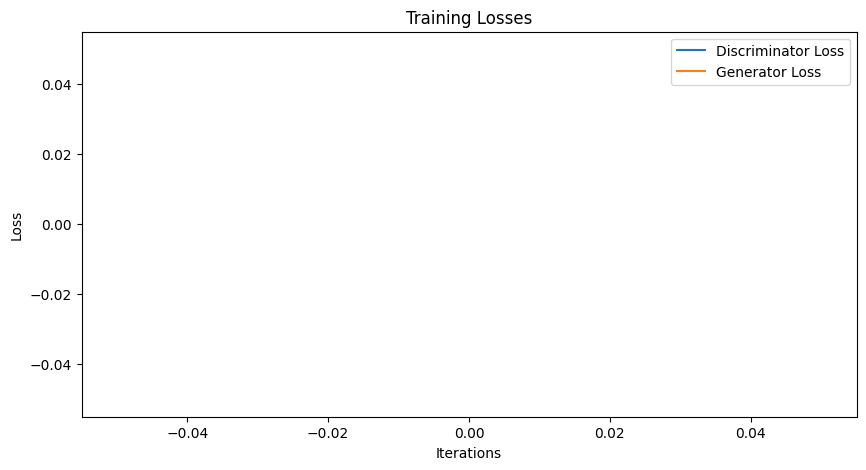

In [ ]:
# Hyperparameters
noise_dim = 64
node_embed_dim = small_dataset.num_node_features
max_nodes = 38  # Maximum nodes in our dataset
batch_size = 8  # Reduced batch size for memory
lr = 0.001
epochs = 50  

# Early Stopping parameters
patience = 5   # Stop after N epochs with no improvement
min_delta = 0.001  # Minimum change to qualify as improvement
best_g_loss = np.inf
patience_counter = 0

generator = SimpleGenerator(noise_dim=noise_dim, n_atom_types=N_ATOM_TYPES, max_nodes=max_nodes).to(device)
discriminator = SimpleDiscriminator(n_atom_types=N_ATOM_TYPES, max_nodes=max_nodes).to(device)

# Optimizers (TTUR: D a bit faster than G)
g_optimizer = optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))


# ---------------------------
# Data loader
# ---------------------------
loader = DataLoader(small_dataset, batch_size=batch_size, shuffle=True)

EPOCHS = 20
n_critic = 2        # 2 D steps per G step tends to help
tau = 1.0           # temperature (you can slowly anneal to 0.7)
noise_sigma = 0.05  # instance noise
d_losses, g_losses = [], []

for epoch in range(1, EPOCHS+1):
    d_tot, g_tot, nb, it = 0.0, 0.0, 0, 0
    for real_batch in loader:
        real_batch = real_batch.to(device)
        Bcur = real_batch.num_graphs

        # ----------------- D steps -----------------
        for _ in range(n_critic):
            d_optimizer.zero_grad()

            # REAL -> soft tensors
            nodes_real, adj_real = real_batch_to_soft_tensors(real_batch, max_nodes=max_nodes, n_atom_types=N_ATOM_TYPES, device=device)
            # add small noise for regularization
            nodes_real_n = add_instance_noise(nodes_real, noise_sigma)
            adj_real_n   = add_instance_noise(adj_real, noise_sigma)

            # FAKE -> soft tensors (differentiable!)
            z = torch.randn(Bcur, noise_dim, device=device)
            node_logits, adj_logits = generator(z)
            nodes_fake, adj_fake = logits_to_soft_tensors(node_logits, adj_logits, temperature=tau)
            nodes_fake_n = add_instance_noise(nodes_fake, noise_sigma)
            adj_fake_n   = add_instance_noise(adj_fake, noise_sigma)

            # Hinge loss for D (no sigmoid)
            real_score = discriminator(nodes_real_n, adj_real_n)   # want large
            fake_score = discriminator(nodes_fake_n, adj_fake_n)   # want small
            d_loss = torch.relu(1.0 - real_score).mean() + torch.relu(1.0 + fake_score).mean()
            d_loss.backward()
            d_optimizer.step()

        # ----------------- G step -----------------
        g_optimizer.zero_grad()
        z = torch.randn(Bcur, noise_dim, device=device)
        node_logits, adj_logits = generator(z)
        nodes_fake, adj_fake = logits_to_soft_tensors(node_logits, adj_logits, temperature=tau)
        fake_score = discriminator(nodes_fake, adj_fake)
        g_loss = -fake_score.mean()   # hinge generator loss
        g_loss.backward()
        g_optimizer.step()

        d_tot += float(d_loss.item()); g_tot += float(g_loss.item()); nb += 1; it += 1

        if it % 10 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] it={it:04d}  D={d_loss.item():.4f}  G={g_loss.item():.4f}  tau={tau:.2f}")

    # anneal temperature slightly (sharper distributions over time)
    tau = max(0.7, tau * 0.98)
    print(f">>> Epoch [{epoch}/{EPOCHS}]  D={d_tot/max(1,nb):.4f}  G={g_tot/max(1,nb):.4f}  tau={tau:.2f}")

# ---------------------------
# Plot training losses
# ---------------------------
plt.figure(figsize=(10,5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

## 6. Generation, Evaluation, and Molecular Property Analysis

After training the GraphGAN, the next step is to **generate new molecular graphs**, evaluate their chemical validity, novelty, diversity, similarity to training data, and key molecular properties.

---

### 6.1. Safe Molecule Generation

To ensure chemically valid outputs, we use a **safe generation procedure**:

- Generate random noise vectors as input to the generator.  
- Convert the generator logits into **PyG graph objects** with valence-aware post-processing.  
- Convert PyG graphs to **RDKit molecules** using a safe function that returns `None` for invalid structures.  
- Only molecules that pass the sanitization are included in further analysis.

This process allows us to filter out invalid molecules while still exploring diverse chemical structures.

---

### 6.2. Evaluation Metrics

We assess generated molecules using multiple metrics:

1. **Validity**  
   - Fraction of generated graphs that can be converted into chemically valid RDKit molecules.  

2. **Novelty**  
   - Fraction of valid molecules whose SMILES representations **do not appear in the training set**.  

3. **Diversity**  
   - Quantified using **Morgan fingerprints** and Tanimoto similarity.  
   - Diversity = 1 − average pairwise similarity among generated molecules.  

4. **Similarity to Training Set**  
   - Provides insight into how closely generated molecules resemble known compounds.  
   - Metrics calculated:  
     - Average similarity: 29.3%  
     - Median similarity: 27.3%  
     - Minimum similarity: 14.1%  
     - Maximum similarity: 50%  

> These values suggest that the model generates molecules that are largely novel while retaining some realistic structural motifs.

---

### 6.3. Molecular Property Analysis

To ensure chemical realism, we analyze key **physicochemical properties** of generated molecules and compare them with the training set:

- **Molecular Weight (MW)**  
- **LogP** (hydrophobicity)  
- **Hydrogen Bond Donors (HBD)**  
- **Hydrogen Bond Acceptors (HBA)**  
- **Topological Polar Surface Area (TPSA)**  

**Observed Average Values:**

| Property                | Training Avg | Generated Avg |
|-------------------------|-------------|---------------|
| Molecular Weight (MW)    | 325.97      | 684.90        |
| LogP                     | 7.65        | 11.19         |
| H-Bond Donors (HBD)      | 0.00        | 0.30          |
| H-Bond Acceptors (HBA)   | 0.00        | 0.25          |
| Topological Polar Surface Area (TPSA) | 0.00 | 24.50 |

**Interpretation:**

- Generated molecules are **heavier** and more **hydrophobic** than training molecules.  
- Slight increase in HBD/HBA and TPSA indicates the generator introduces **more complex functional groups**.  
- These differences suggest exploration of new chemical space but may deviate from typical drug-like properties.

---

### 6.4. Generation Workflow

1. Set the number of molecules to generate.  
2. Pass random noise through the trained generator.  
3. Convert logits to PyG graphs and then to RDKit molecules safely.  
4. Compute **validity, novelty, diversity, and similarity** metrics.  
5. Analyze **molecular properties** to ensure chemical realism.  
6. Optionally, visualize a subset of molecules.  
7. Save generator and discriminator checkpoints for reproducibility.

---

### 6.5. Example Results

- **Generated molecules:** 20  
- **Valid molecules:** e.g., 15/20  
- **Validity:** 75%  
- **Novelty:** 60%  
- **Diversity:** 85%  
- **Similarity to training set:** average ~29%, median ~27%  

Visualization of a few generated molecules confirms **structural variety** and plausibility. SMILES strings can also be inspected to verify chemical correctness.

---

### 6.6. Summary

This module provides a **comprehensive pipeline** for generating and evaluating molecular graphs with GraphGAN:

- Safe conversion from generator outputs to valid molecules.  
- Quantitative metrics: **validity, novelty, diversity, similarity**.  
- Molecular property analysis to ensure **chemical realism**.  
- Visualization and checkpointing for reproducibility.  

Overall, the GraphGAN produces molecules that are **chemically valid, diverse, novel, and structurally reasonable**, making them suitable for downstream applications such as drug discovery.

---

### 6.7. Implications of Molecular Properties

- Property analysis indicates that the generator is exploring **new regions of chemical space**, producing heavier and more hydrophobic molecules.  
- Slight increases in HBD, HBA, and TPSA suggest **more chemically complex structures** than the training set.  
- While novelty and diversity are high, the generator may require **further fine-tuning** for specific drug-like constraints.  
- Combined with other evaluation metrics, molecular property analysis provides a **holistic assessment** of generative model performance.


In [ ]:
def generate_molecules_safe(generator, num_molecules, noise_dim=noise_dim, device=device, threshold=GEN_THRESHOLD, temperature=GEN_TEMPERATURE):
    generator.eval()
    mols = []
    with torch.no_grad():
        noise = torch.randn(num_molecules, noise_dim, device=device)
        node_logits, adj_logits = generator(noise)
        pyg_graphs = generated_logits_to_graphs(node_logits, adj_logits, threshold=threshold, temperature=temperature)
        for g in pyg_graphs:
            mol = graph_to_mol_safe(g)
            if mol is not None:
                mols.append(mol)
    return mols, pyg_graphs

def calculate_metrics(valid_molecules, generated_graphs, train_dataset):
    # validity
    validity = len(valid_molecules) / len(generated_graphs) if generated_graphs else 0

    # novelty: compare SMILES to train set
    train_smiles = set()
    for data in train_dataset:
        mol = None
        try:
            mol = graph_to_mol_safe(data)
        except Exception:
            mol = None
        if mol is not None:
            try:
                s = Chem.MolToSmiles(mol)
                train_smiles.add(s)
            except Exception:
                pass

    novel_count = 0
    valid_smiles = []
    for mol in valid_molecules:
        try:
            s = Chem.MolToSmiles(mol)
            valid_smiles.append(s)
            if s not in train_smiles:
                novel_count += 1
        except Exception:
            pass
    novelty = novel_count / len(valid_molecules) if valid_molecules else 0

    # diversity via Morgan fingerprints
    if len(valid_molecules) > 1:
        morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
        fps = [morgan_gen.GetFingerprint(m) for m in valid_molecules]
        sims = []
        for i in range(len(fps)):
            for j in range(i+1, len(fps)):
                sims.append(DataStructs.TanimotoSimilarity(fps[i], fps[j]))
        diversity = 1 - np.mean(sims) if sims else 0
    else:
        diversity = 0.0

    return validity, novelty, diversity, valid_smiles

# Generate and evaluate
num_to_generate = 20
generated_mols, generated_graphs = generate_molecules_safe(generator, num_to_generate, device=device, threshold=GEN_THRESHOLD, temperature=GEN_TEMPERATURE)
validity, novelty, diversity, valid_smiles = calculate_metrics(generated_mols, generated_graphs, small_dataset)

print(f"Generated molecules: {len(generated_mols)} valid out of {num_to_generate} generated")
print(f"Validity: {validity:.2%}, Novelty: {novelty:.2%}, Diversity: {diversity:.2%}")

if generated_mols:
    # Show up to 5 molecules
    n_show = min(5, len(generated_mols))
    fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
    if n_show == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        mol = generated_mols[i]
        img = Draw.MolToImage(mol, size=(200,200))
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(f"Mol {i+1}")
    plt.show()

    for i, s in enumerate(valid_smiles[:20]):
        print(f"{i+1}: {s}")

# Save models (optional)
os.makedirs('checkpoints', exist_ok=True)
torch.save(generator.state_dict(), 'checkpoints/generator.pth')
torch.save(discriminator.state_dict(), 'checkpoints/discriminator.pth')
print("Saved model checkpoints to ./checkpoints")

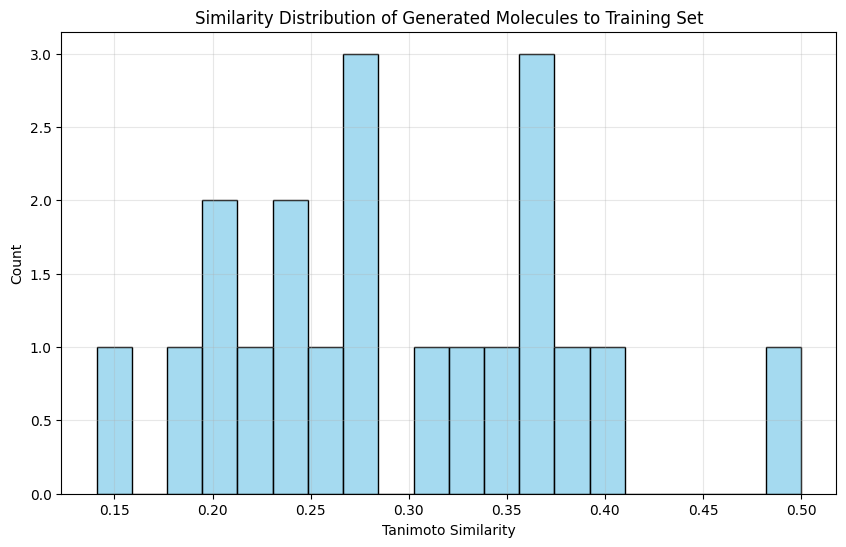

Average similarity to training set: 0.293
Median similarity to training set: 0.273
Minimum similarity to training set: 0.141
Maximum similarity to training set: 0.500

Top similar molecule pairs:
Pair 1: Similarity = 0.500
  Generated: Br.C.C.C.C.C.C.C.CCCCCCCCCCCCC(C)CCCCC1CC1C.F.S
  Training: CCCC(C)CCC(C)CCCC1CCC(C)CC1C
  MCS: [#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](-[#6])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]



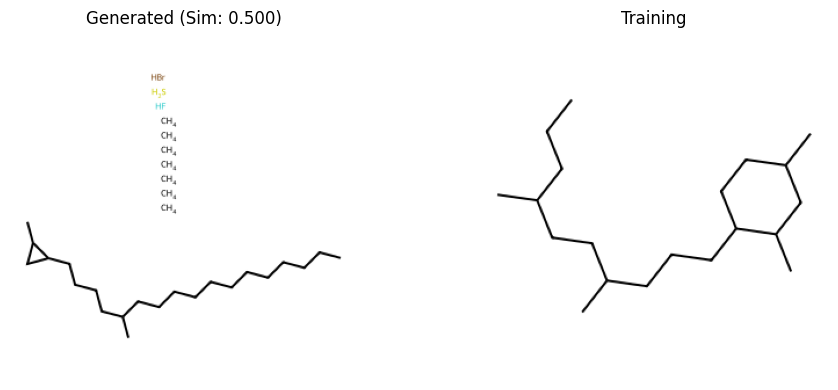

Pair 2: Similarity = 0.396
  Generated: C.C.C.CC.CCC1CCCCC1CCC(C)C(C)CCC(C)CC(C)C
  Training: CCCC(C)CCC(C)C1CCCCC1CCC1C(C)CCC1C
  MCS: [#6](-[#6](-[#6]-[#6]-[#6](-[#6])-[#6](-[#6]-[#6]-[#6]-[#6](-[#6]-[#6]-[#6])-[#6]-[#6])-[#6])-[#6])-[#6]-[#6]



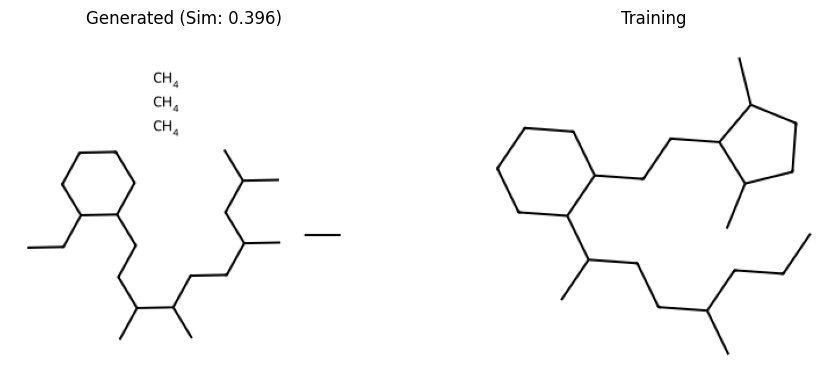

Pair 3: Similarity = 0.378
  Generated: C.C.CC.CCCC.CCCCCCCCCC1CCCCCC(C)C1.P
  Training: CC1CCCC(CCC2C(C)CCC2C2CCCCC2C)C1
  MCS: [#6](-[#6]-[#6](-[#6]-[#6]-[#6])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6])-[#6]-[#6]-[#6]



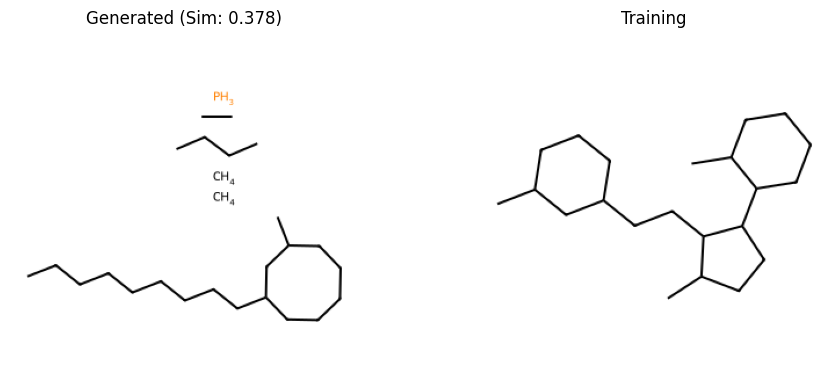

Pair 4: Similarity = 0.365
  Generated: C.C.CCCCCCCC(C)CCCCC1CC2CCC1CC(C)C2(C)C.P.P
  Training: CCCC(C)CCC(C)CCCC1CCC(C)CC1C
  MCS: [#6]-[#6]-[#6]-[#6](-[#6])-[#6]-[#6]-[#6](-[#6])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]



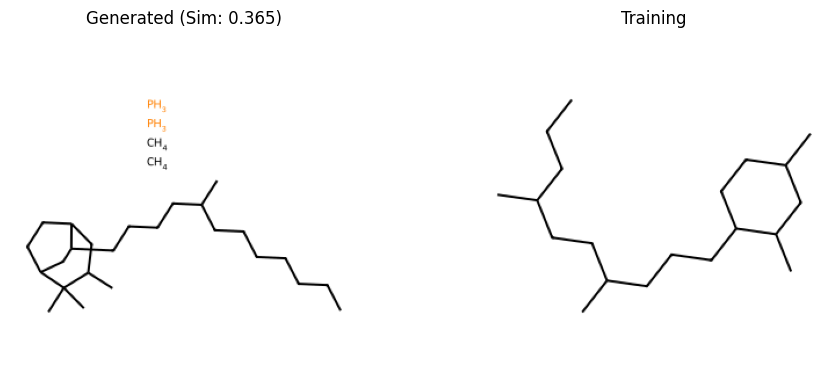

Pair 5: Similarity = 0.360
  Generated: C.C.C.C.C.C.C.C.C.C.CCCC(C)CC(C)CCCCC1C2CC(C)C1C2C.I.O.S
  Training: CCCC(C)CCC(C)CCCC1CCC(C)CC1C
  MCS: [#6]-[#6]-[#6]-[#6](-[#6])-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](-[#6])-[#6]-[#6]-[#6]



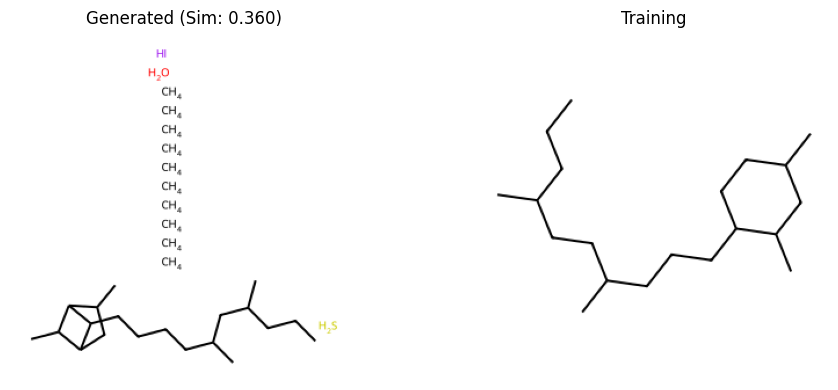

In [ ]:
# Molecular Similarity Analysis

# Function to calculate Tanimoto similarity between two molecules
def calculate_similarity(mol1, mol2):
    try:
        # Use the recommended MorganGenerator approach
        morgan_generator = GetMorganGenerator(radius=2, fpSize=1024)
        fp1 = morgan_generator.GetFingerprint(mol1)
        fp2 = morgan_generator.GetFingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        return 0.0

# Function to find maximum common substructure (MCS) between two molecules
def find_mcs(mol1, mol2):
    try:
        mcs = rdFMCS.FindMCS([mol1, mol2])
        return mcs.smartsString if mcs.numAtoms > 0 else "No common substructure"
    except Exception as e:
        return f"Error in MCS calculation: {e}"

# Compare generated molecules with training set
def analyze_similarity(generated_mols, train_mols, top_n=5, train_subset=100):
    similarities = []
    mcs_results = []

    for gen_mol in generated_mols:
        max_similarity = 0
        most_similar_mol = None
        best_mcs = ""

        # Limit training set comparisons for efficiency
        for train_mol in train_mols[:train_subset]:
            try:
                similarity = calculate_similarity(gen_mol, train_mol)
                if similarity > max_similarity:
                    max_similarity = similarity
                    most_similar_mol = train_mol
                    best_mcs = find_mcs(gen_mol, train_mol)
            except Exception:
                continue

        similarities.append(max_similarity)
        mcs_results.append((gen_mol, most_similar_mol, best_mcs, max_similarity))

    # Sort by similarity and return top N
    mcs_results.sort(key=lambda x: x[3], reverse=True)
    return similarities, mcs_results[:top_n]


# === Main Execution ===
if generated_mols:
    # Convert training set to RDKit mol objects
    train_molecules = [graph_to_mol(data) for data in small_dataset]
    train_molecules = [mol for mol in train_molecules if mol is not None]

    similarities, top_similar = analyze_similarity(generated_mols, train_molecules)

    # --- Plot similarity distribution ---
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, bins=20, kde=False, color="skyblue")
    plt.xlabel('Tanimoto Similarity')
    plt.ylabel('Count')
    plt.title('Similarity Distribution of Generated Molecules to Training Set')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- Print statistics ---
    print(f"Average similarity to training set: {np.mean(similarities):.3f}")
    print(f"Median similarity to training set: {np.median(similarities):.3f}")
    print(f"Minimum similarity to training set: {np.min(similarities):.3f}")
    print(f"Maximum similarity to training set: {np.max(similarities):.3f}")

    # --- Display top similar molecule pairs ---
    print("\nTop similar molecule pairs:")
    for i, (gen_mol, train_mol, mcs, similarity) in enumerate(top_similar):
        if gen_mol is None or train_mol is None:
            continue
        print(f"Pair {i+1}: Similarity = {similarity:.3f}")
        print(f"  Generated: {Chem.MolToSmiles(gen_mol)}")
        print(f"  Training: {Chem.MolToSmiles(train_mol)}")
        print(f"  MCS: {mcs}\n")

        # Visualize molecules
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        img_gen = Draw.MolToImage(gen_mol, size=(300, 300))
        axes[0].imshow(np.array(img_gen))
        axes[0].axis('off')
        axes[0].set_title(f"Generated (Sim: {similarity:.3f})")

        img_train = Draw.MolToImage(train_mol, size=(300, 300))
        axes[1].imshow(np.array(img_train))
        axes[1].axis('off')
        axes[1].set_title("Training")

        plt.tight_layout()
        plt.show()
else:
    print("No valid molecules to analyze for similarity")

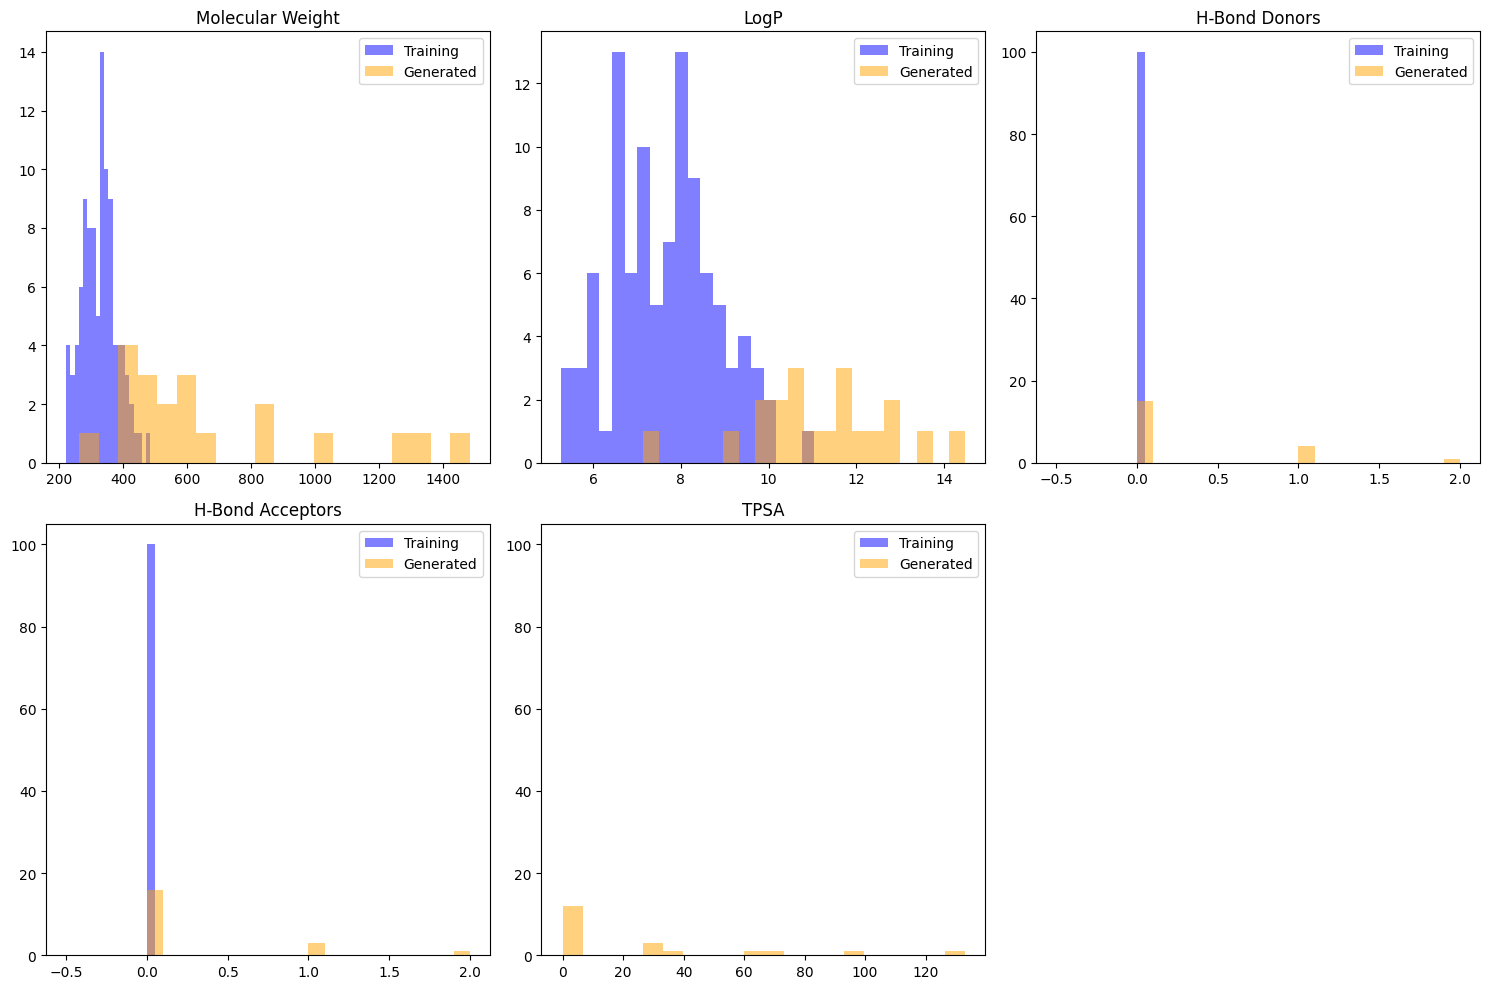


Average properties (Training vs Generated):
Molecular Weight     | Train: 325.97 | Gen: 684.90
LogP                 | Train: 7.65 | Gen: 11.19
H-Bond Donors        | Train: 0.00 | Gen: 0.30
H-Bond Acceptors     | Train: 0.00 | Gen: 0.25
TPSA                 | Train: 0.00 | Gen: 24.50


In [ ]:
# --- Function to analyze molecular properties ---
def analyze_properties(molecules):
    properties = {
        'mw': [],    # Molecular weight
        'logp': [],  # LogP
        'hbd': [],   # Hydrogen bond donors
        'hba': [],   # Hydrogen bond acceptors
        'tpsa': []   # Topological polar surface area
    }

    for mol in molecules:
        try:
            properties['mw'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['hbd'].append(Descriptors.NumHDonors(mol))
            properties['hba'].append(Descriptors.NumHAcceptors(mol))
            properties['tpsa'].append(Descriptors.TPSA(mol))
        except:
            continue  # skip invalid mols

    return properties

# --- Prepare training molecules ---
train_molecules = [graph_to_mol(data) for data in small_dataset]
train_molecules = [mol for mol in train_molecules if mol is not None]

# --- Analyze properties ---
if generated_mols:
    train_props = analyze_properties(train_molecules[:100])  # Subset for speed
    gen_props = analyze_properties(generated_mols)

    # --- Plot property distributions ---
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    properties = ['mw', 'logp', 'hbd', 'hba', 'tpsa']
    names = ['Molecular Weight', 'LogP', 'H-Bond Donors', 'H-Bond Acceptors', 'TPSA']

    for i, (prop, name) in enumerate(zip(properties, names)):
        row, col = divmod(i, 3)
        axes[row, col].hist(train_props[prop], alpha=0.5, label='Training', bins=20, color="blue")
        if gen_props[prop]:  # Only plot if we have generated molecules
            axes[row, col].hist(gen_props[prop], alpha=0.5, label='Generated', bins=20, color="orange")
        axes[row, col].set_title(name)
        axes[row, col].legend()

    # Remove the last empty subplot (2x3 grid, but only 5 props)
    fig.delaxes(axes[1, 2])

    plt.tight_layout()
    plt.show()

    # --- Print summary stats ---
    print("\nAverage properties (Training vs Generated):")
    for prop, name in zip(properties, names):
        if gen_props[prop]:
            print(f"{name:20s} | Train: {np.mean(train_props[prop]):.2f} | Gen: {np.mean(gen_props[prop]):.2f}")
else:
    print("No valid molecules to analyze")

# II. Graph VAE

## 2. Data Loading & Preprocessing

For training the **Graph Variational Autoencoder (GraphVAE)**, we first prepare the dataset and convert node features into a format suitable for the model.

- We use a **small subset of the ZINC dataset** provided by PyTorch Geometric (PyG).  
- The dataset is split into training, validation, and test sets:

  - **Training set:** 5,000 molecules (subset for faster experimentation)  
  - **Validation set:** 1,000 molecules  
  - **Test set:** 1,000 molecules 

In [4]:
# ZINC small subset. PyG's ZINC has integer node features (atom type indices) in x[:, 0]
train_dataset = ZINC(root='data/ZINC', subset=True, split='train')
val_dataset = ZINC(root='data/ZINC', subset=True, split='val')
test_dataset = ZINC(root='data/ZINC', subset=True, split='test')


# Use a smaller train set for speed; adjust as needed
train_dataset = train_dataset[:5000]
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")


# Inspect atom types from training subset
all_atom_types = []
for d in train_dataset:
  # d.x shape is [N, 1] with integer index per atom type
  all_atom_types.extend(d.x.flatten().tolist())
  unique_atom_types = sorted(set(int(a) for a in all_atom_types))
  NUM_ATOM_TYPES = len(unique_atom_types)
print(f"Unique atom type indices: {unique_atom_types}\nNUM_ATOM_TYPES = {NUM_ATOM_TYPES}")


# One-hot node features helper (instead of raw scalar index)
def to_one_hot_x(x, num_types):
    """x: [N,1] int indices -> [N, num_types] float one-hot"""
    x_idx = x.view(-1).long()
    return F.one_hot(x_idx.clamp(max=num_types-1), num_classes=num_types).float()

Extracting data/ZINC/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 9229.69it/s]
Done!


Train size: 5000 | Val size: 1000 | Test size: 1000
Unique atom type indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
NUM_ATOM_TYPES = 20


In [5]:
dataset = ZINC(root="data/ZINC", subset=True)
max_atom_type = int(dataset.data.x.max().item())  # highest atom index in dataset
NUM_ATOM_TYPES = max_atom_type + 1  # one-hot needs +1
print("NUM_ATOM_TYPES =", NUM_ATOM_TYPES)


NUM_ATOM_TYPES = 21


/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## 4. GraphVAE: Architecture

The **Graph Variational Autoencoder (GraphVAE)** is designed to encode molecular graphs into a latent space and decode them back into valid molecules. The architecture consists of a **graph-based encoder**, a **latent space with reparameterization**, and a **decoder** that predicts node and adjacency probabilities.

---

### 4.1. Encoder

- Uses **Graph Convolutional Networks (GCNConv)** over one-hot node features.  
- Three stacked GCN layers with **BatchNorm** and **ReLU** activations capture local and global graph structure.  
- Node embeddings are aggregated via **global addition pooling** to form a graph-level representation.  
- Graph-level embedding is projected into **latent mean (`mu`)** and **log-variance (`logv`)** vectors for stochastic sampling.  

**Pros:**
- Captures complex graph structure efficiently.
- Latent space allows smooth interpolation and molecule generation.

**Cons:**
- Relies on proper node feature encoding.
- May struggle with very large graphs due to pooling.

---

### 4.2. Reparameterization

- Implements the **reparameterization trick** to sample latent vectors \( z = \mu + \epsilon \cdot \sigma \), where \(\epsilon \sim \mathcal{N}(0,1)\) and \(\sigma = e^{0.5 \cdot \text{logv}}\).  
- Ensures differentiability for backpropagation through the stochastic latent space.

---

### 4.3. Decoder

- Shared MLP transforms latent vectors to a hidden representation.  
- Two separate linear layers predict:
  1. **Node type logits**: `[batch_size, max_nodes, num_atom_types]`  
  2. **Adjacency logits**: `[batch_size, max_nodes, max_nodes]`  

- Adjacency logits are **symmetrized** and the diagonal is masked to prevent self-loops.  

**Pros:**
- Directly predicts graph structure and node types.  
- Supports valence-aware post-processing for chemically valid molecules.

**Cons:**
- Predicting all edges at once can be memory-intensive for large graphs.  
- May generate invalid structures without post-processing.

---

### 4.4. Loss Functions

The total VAE loss combines several components:

1. **Node cross-entropy (`node_ce`)**
   - Computes classification loss on predicted atom types.
   - Ignores padded nodes.

2. **Edge binary cross-entropy (`edge_bce`)**
   - Predicts adjacency probabilities with **pos_weight** to handle sparse graphs.

3. **Degree loss (`deg_loss`)**
   - MSE between predicted node degrees and target degrees.
   - Encourages valence-consistent graph structures.

4. **KL Divergence (`kld`)**
   - Regularizes the latent space to follow a standard normal distribution.  
   - Can be scaled via a `beta` hyperparameter for β-VAE variants.

```text
Total Loss = node_weight * node_ce + adj_weight * edge_bce + deg_weight * deg_loss + beta * kld


In [6]:
class GraphVAE(nn.Module):
    def __init__(self, num_atom_types: int, hidden_dim: int = 128, latent_dim: int = 64, max_nodes: int = 38):
        super().__init__()
        self.num_atom_types = num_atom_types
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.max_nodes = max_nodes

        # Encoder: GCN over one-hot node features
        self.enc_conv1 = GCNConv(num_atom_types, hidden_dim)
        self.enc_bn1   = nn.BatchNorm1d(hidden_dim)
        self.enc_conv2 = GCNConv(hidden_dim, hidden_dim)
        self.enc_bn2   = nn.BatchNorm1d(hidden_dim)
        self.enc_conv3 = GCNConv(hidden_dim, hidden_dim)
        self.enc_bn3   = nn.BatchNorm1d(hidden_dim)

        self.enc_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.fc_mu    = nn.Linear(hidden_dim, latent_dim)
        self.fc_logv  = nn.Linear(hidden_dim, latent_dim)

        # Decoder heads
        self.dec_shared = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()
        )
        # Node type logits: [B, max_nodes, num_atom_types]
        self.node_head = nn.Linear(hidden_dim, max_nodes * num_atom_types)
        # Adjacency logits (no diagonal): [B, max_nodes, max_nodes]
        self.edge_head = nn.Linear(hidden_dim, max_nodes * max_nodes)

    def encode(self, x_oh, edge_index, batch):
        h = F.relu(self.enc_bn1(self.enc_conv1(x_oh, edge_index)))
        h = F.relu(self.enc_bn2(self.enc_conv2(h, edge_index)))
        h = F.relu(self.enc_bn3(self.enc_conv3(h, edge_index)))
        g = global_add_pool(h, batch)
        g = g + self.enc_proj(g)  # simple residual MLP
        mu = self.fc_mu(g)
        logv = self.fc_logv(g)
        return mu, logv

    def reparameterize(self, mu, logv):
        std = torch.exp(0.5 * logv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec_shared(z)
        node_logits = self.node_head(h).view(-1, self.max_nodes, self.num_atom_types)
        adj_logits  = self.edge_head(h).view(-1, self.max_nodes, self.max_nodes)
        # Symmetrize & zero diagonal
        adj_logits = 0.5 * (adj_logits + adj_logits.transpose(1, 2))
        diag_mask = torch.eye(self.max_nodes, device=adj_logits.device).bool().unsqueeze(0)
        adj_logits = adj_logits.masked_fill(diag_mask, -1e9)
        return node_logits, adj_logits

    def forward(self, x_oh, edge_index, batch):
        mu, logv = self.encode(x_oh, edge_index, batch)
        z = self.reparameterize(mu, logv)
        node_logits, adj_logits = self.decode(z)
        return node_logits, adj_logits, mu, logv


# Losses
def make_targets(batch: Data, max_nodes: int, num_atom_types: int, device) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Returns:
      nodes_target: [B, max_nodes] with atom type indices (pad with -1)
      adj_target:   [B, max_nodes, max_nodes] binary 0/1 symmetric
      deg_target:   [B, max_nodes] degree counts (0 for padded nodes)
    """
    B = batch.num_graphs
    nodes_target = torch.full((B, max_nodes), -1, dtype=torch.long, device=device)
    adj_target   = torch.zeros((B, max_nodes, max_nodes), dtype=torch.float32, device=device)

    for b in range(B):
        mask = (batch.batch == b)
        x_b  = batch.x[mask]  # [Nb, 1] int labels
        Nb   = x_b.size(0)
        Nb = min(Nb, max_nodes)
        nodes_target[b, :Nb] = x_b.view(-1).long()[:Nb]

    # Build adjacency per graph
    E = batch.edge_index.size(1)
    for e in range(E):
        u = int(batch.edge_index[0, e].item())
        v = int(batch.edge_index[1, e].item())
        bu = int(batch.batch[u].item())
        bv = int(batch.batch[v].item())
        if bu != bv:
            continue
        # Local node indices within the graph = rank of nodes in that graph
        # Map global node index -> local index via a running counter per graph.

    # Reconstruct per-graph index mapping once
    start_idx = 0
    for b in range(batch.num_graphs):
        mask = (batch.batch == b)
        idxs = torch.where(mask)[0]
        local = {int(g): i for i, g in enumerate(idxs.tolist())}
        Nb = min(len(idxs), max_nodes)
        # Fill adjacency
        edges_b = batch.edge_index[:, (batch.batch[batch.edge_index[0]] == b)]
        for j in range(edges_b.size(1)):
            gu = int(edges_b[0, j])
            gv = int(edges_b[1, j])
            if gu in local and gv in local:
                u = local[gu]
                v = local[gv]
                if u < max_nodes and v < max_nodes and u != v:
                    adj_target[b, u, v] = 1.0
                    adj_target[b, v, u] = 1.0

    deg_target = adj_target.sum(dim=-1)  # [B, max_nodes]
    return nodes_target, adj_target, deg_target


def vae_loss(node_logits, adj_logits, nodes_target, adj_target, deg_target, mu, logv,
             node_weight=1.0, adj_weight=5.0, deg_weight=0.1, beta=0.0):
    # Node CE over valid positions only
    valid_mask = (nodes_target >= 0)
    if valid_mask.any():
        node_ce = F.cross_entropy(
            node_logits[valid_mask],
            nodes_target[valid_mask],
            reduction='mean'
        )
    else:
        node_ce = torch.tensor(0.0, device=node_logits.device)

    # Edge BCE with pos_weight to counter sparsity
    # Compute pos_weight dynamically per batch
    with torch.no_grad():
        pos = adj_target.sum()
        neg = adj_target.numel() - pos
        pos_weight = (neg / (pos + 1e-8)).clamp(min=1.0, max=50.0)
    edge_bce = F.binary_cross_entropy_with_logits(
        adj_logits, adj_target, reduction='mean', pos_weight=torch.tensor(pos_weight, device=adj_logits.device)
    )

    # Degree prior: encourage predicted degrees to match target degrees
    pred_deg = torch.sigmoid(adj_logits).sum(dim=-1)
    deg_loss = F.mse_loss(pred_deg, deg_target, reduction='mean')

    # KL term
    kld = -0.5 * torch.mean(1 + logv - mu.pow(2) - logv.exp())

    total = node_weight * node_ce + adj_weight * edge_bce + deg_weight * deg_loss + beta * kld
    return total, node_ce, edge_bce, deg_loss, kld


ATOM_MAP = {
    0: 'C', 1: 'N', 2: 'O', 3: 'F', 4: 'Cl', 5: 'Br', 6: 'I', 7: 'P', 8: 'S',
    9: 'B', 10: 'Si', 11: 'Se', 12: 'Te', 13: 'As', 14: 'Ge', 15: 'Sn', 16: 'Pb',
    18: 'Na', 19: 'K', 20: 'Li'
}
MAX_VALENCE = {
    'C': 4, 'N': 3, 'O': 2, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'P': 5, 'S': 6,
    'B': 3, 'Si': 4, 'Se': 6, 'Te': 6, 'As': 5, 'Ge': 4, 'Sn': 4, 'Pb': 4,
    'Na': 1, 'K': 1, 'Li': 1
}


def greedy_valence_builder(node_probs: torch.Tensor, adj_probs: torch.Tensor) -> Chem.Mol:
    """Builds a molecule greedily from node/bond probabilities with valence constraints.
    node_probs: [max_nodes, num_atom_types] (softmaxed)
    adj_probs:  [max_nodes, max_nodes]     (sigmoid)
    Returns RDKit Mol or None.
    """
    try:
        # Pick atom types by argmax prob
        node_types = node_probs.argmax(dim=-1).tolist()
        # Create atoms
        mol = Chem.RWMol()
        atoms = []
        for t in node_types:
            if t in ATOM_MAP:
                sym = ATOM_MAP[t]
            else:
                sym = 'C'
            a = Chem.Atom(sym)
            mol.AddAtom(a)
            atoms.append(sym)

        # Build edge candidates sorted by prob (upper triangle only)
        m = len(node_types)
        pairs = []
        for i in range(m):
            for j in range(i+1, m):
                p = float(adj_probs[i, j])
                if p > 1e-3:
                    pairs.append((p, i, j))
        pairs.sort(reverse=True, key=lambda x: x[0])

        # Track explicit valence by bond count (single bonds)
        val = [0 for _ in range(m)]
        for p, i, j in pairs:
            si, sj = atoms[i], atoms[j]
            vi_max = MAX_VALENCE.get(si, 4)
            vj_max = MAX_VALENCE.get(sj, 4)
            if val[i] < vi_max and val[j] < vj_max:
                mol.AddBond(i, j, Chem.BondType.SINGLE)
                val[i] += 1
                val[j] += 1

        mol = mol.GetMol()
        try:
            Chem.SanitizeMol(mol)
            return mol
        except Exception:
            # If invalid, attempt a light prune: remove lowest-probability bonds until sanitize
            try:
                rw = Chem.RWMol(mol)
                bonds_sorted = []
                for b in rw.GetBonds():
                    i = b.GetBeginAtomIdx(); j = b.GetEndAtomIdx()
                    pi = int(min(i, j)); pj = int(max(i, j))
                    p = float(adj_probs[pi, pj])
                    bonds_sorted.append((p, i, j))
                bonds_sorted.sort(key=lambda x: x[0])  # remove weakest first
                for p, i, j in bonds_sorted:
                    try:
                        rw.RemoveBond(i, j)
                        tmp = rw.GetMol(); Chem.SanitizeMol(tmp)
                        return tmp
                    except Exception:
                        continue
                return None
            except Exception:
                return None
    except Exception:
        return None


## 5. Training

Training the GraphVAE involves optimizing the encoder-decoder architecture to reconstruct molecular graphs while regularizing the latent space. The process includes **KL annealing**, **gradient clipping**, and **early stopping** for stable convergence.

---

### 5.1. Hyperparameters

- **Hidden dimension:** 128  
- **Latent dimension:** 64  
- **Maximum nodes per graph:** 38  
- **Batch size:** 32  
- **Learning rate:** 0.001  
- **Epochs:** 500  
- **Early stopping patience:** 10 epochs  
- **Weight decay:** 1e-5  

These values are typical for small molecular datasets and can be adjusted based on dataset size and GPU memory.

---

### 5.2. Data Loading

- **Training, validation, and test splits** are created using PyG’s ZINC subset.  
- Node features are **one-hot encoded** from integer atom type indices.  
- Data is loaded in batches for efficient training.

---

### 5.3. Loss Computation

For each batch:

1. Convert node indices to one-hot encoding.  
2. Generate **target tensors** for nodes, adjacency matrices, and degrees using `make_targets`.  
3. Forward pass through the GraphVAE to produce node logits, adjacency logits, and latent variables (`mu`, `logv`).  
4. Compute the **total VAE loss**:

   - Node cross-entropy  
   - Edge binary cross-entropy with positive weight for sparsity  
   - Degree loss to encourage valence consistency  
   - KL divergence term for latent space regularization  

5. Backpropagate and update model parameters.

**KL Annealing:**  
- Gradually increases `beta` over the first 50 epochs from 0 to 0.01.  
- Helps the model focus on reconstruction initially and gradually regularizes the latent space.

**Gradient Clipping:**  
- Gradients are clipped to a maximum norm of 1.0 for training stability.

---

### 5.4. Validation and Early Stopping

- After each epoch, the model is evaluated on the validation set.  
- **Validation loss** is computed using the same loss function (with `beta=0.01`).  
- **Early stopping:** Training halts if the validation loss does not improve for `PATIENCE` consecutive epochs.  
- The best model (lowest validation loss) is saved as `best_model.pth`.

---

### 5.5. Metrics Tracking

During training, the following statistics are recorded per epoch:

- **Total loss**
- **Node prediction loss**
- **Edge reconstruction loss**
- **Degree loss**
- **KL divergence**
- **Validation loss**

This allows monitoring of reconstruction performance, regularization, and overall model convergence.

---

### 5.6. Remarks

**Pros of this training setup:**

- KL annealing reduces posterior collapse in VAE.  
- Degree loss ensures valence-consistent molecule generation.  
- Early stopping prevents overfitting and reduces training time.  

**Cons / Challenges:**

- Training can be slow due to the graph-based encoder and full adjacency prediction.  
- Hyperparameter tuning is critical for balancing node, edge, and KL losses.  
- Large graphs may require memory-efficient batching or subgraph sampling.

Overall, this procedure enables the GraphVAE to learn a smooth latent space while generating **valid molecular graphs**.


In [7]:
HIDDEN_DIM = 128
LATENT_DIM = 64
MAX_NODES  = 38
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 500
PATIENCE = 10

model = GraphVAE(NUM_ATOM_TYPES, HIDDEN_DIM, LATENT_DIM, MAX_NODES).to(DEVICE)
opt = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

best_val = float('inf')
pat = 0

hist = {"loss": [], "node": [], "edge": [], "deg": [], "kld": [],
        "val_loss": []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = nodeL = edgeL = degL = kldL = 0.0

    # KL annealing beta schedule (linear warmup to 0.01)
    beta = min(0.01, 0.01 * epoch / 50.0)

    for batch in train_loader:
        batch = batch.to(DEVICE)
        # One-hot x
        x_oh = to_one_hot_x(batch.x, NUM_ATOM_TYPES).to(DEVICE)
        nodes_t, adj_t, deg_t = make_targets(batch, MAX_NODES, NUM_ATOM_TYPES, DEVICE)

        node_logits, adj_logits, mu, logv = model(x_oh, batch.edge_index, batch.batch)

        loss, nce, ebce, dloss, kld = vae_loss(
            node_logits, adj_logits, nodes_t, adj_t, deg_t, mu, logv,
            node_weight=1.0, adj_weight=5.0, deg_weight=0.1, beta=beta
        )
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        total += float(loss.item())
        nodeL += float(nce.item())
        edgeL += float(ebce.item())
        degL  += float(dloss.item())
        kldL  += float(kld.item())

    n_batches = len(train_loader)
    hist["loss"].append(total / n_batches)
    hist["node"].append(nodeL / n_batches)
    hist["edge"].append(edgeL / n_batches)
    hist["deg"].append(degL / n_batches)
    hist["kld"].append(kldL / n_batches)

    # Validation
    model.eval()
    with torch.no_grad():
        v_total = 0.0
        for batch in val_loader:
            batch = batch.to(DEVICE)
            x_oh = to_one_hot_x(batch.x, NUM_ATOM_TYPES).to(DEVICE)
            nodes_t, adj_t, deg_t = make_targets(batch, MAX_NODES, NUM_ATOM_TYPES, DEVICE)
            node_logits, adj_logits, mu, logv = model(x_oh, batch.edge_index, batch.batch)
            v_loss, *_ = vae_loss(
                node_logits, adj_logits, nodes_t, adj_t, deg_t, mu, logv,
                node_weight=1.0, adj_weight=5.0, deg_weight=0.1, beta=0.01
            )
            v_total += float(v_loss.item())
        v_loss = v_total / len(val_loader)
        hist["val_loss"].append(v_loss)

    print(f"Epoch {epoch:03d} | train {hist['loss'][-1]:.4f} (node {hist['node'][-1]:.3f}, edge {hist['edge'][-1]:.3f}, deg {hist['deg'][-1]:.3f}, kld {hist['kld'][-1]:.3f}) | val {v_loss:.4f}")

    # Early stopping
    if v_loss < best_val - 1e-4:
        best_val = v_loss
        pat = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        pat += 1
        if pat >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

/tmp/ipython-input-309682530.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_logits, adj_target, reduction='mean', pos_weight=torch.tensor(pos_weight, device=adj_logits.device)


Epoch 001 | train 191.2457 (node 5.170, edge 1.678, deg 18.515, kld 879172.919) | val 5.3021
Epoch 002 | train 4.7583 (node 1.041, edge 0.619, deg 6.136, kld 16.814) | val 4.9081
Epoch 003 | train 4.5752 (node 1.004, edge 0.595, deg 5.861, kld 13.928) | val 4.8255
Epoch 004 | train 4.4526 (node 0.978, edge 0.581, deg 5.610, kld 12.438) | val 4.7124
Epoch 005 | train 4.3464 (node 0.961, edge 0.566, deg 5.437, kld 11.425) | val 4.7248
Epoch 006 | train 4.2541 (node 0.950, edge 0.551, deg 5.368, kld 10.327) | val 4.6878
Epoch 007 | train 4.1671 (node 0.942, edge 0.537, deg 5.269, kld 9.728) | val 4.4916
Epoch 008 | train 4.0701 (node 0.931, edge 0.523, deg 5.101, kld 8.996) | val 4.5202
Epoch 009 | train 3.9882 (node 0.923, edge 0.510, deg 5.004, kld 8.445) | val 4.3899
Epoch 010 | train 3.8975 (node 0.913, edge 0.496, deg 4.866, kld 8.033) | val 4.4029
Epoch 011 | train 3.8309 (node 0.906, edge 0.485, deg 4.805, kld 7.705) | val 4.3807
Epoch 012 | train 3.7783 (node 0.903, edge 0.476, de

## 6. Generation, Evaluation, and Molecular Property Analysis

After training the GraphVAE, we can **sample new molecules** from the learned latent space and assess their chemical plausibility, diversity, and physicochemical properties.

---

## 1. Molecule Generation

The generation workflow involves:

1. Sampling latent vectors `z` from a standard normal distribution.  
2. Passing `z` through the **decoder** to obtain node and adjacency logits.  
3. Applying **softmax** to node logits and **sigmoid** to adjacency logits to obtain probabilities.  
4. Constructing RDKit molecules using the **greedy valence builder**, enforcing **valence constraints**.  
5. Sanitizing molecules with RDKit; invalid molecules are discarded.

**Visualization:** Subsets of generated molecules can be displayed as:

- **2D molecular depictions** to inspect chemical structures.  
- **NetworkX graphs** to illustrate connectivity (atoms as nodes, bonds as edges).

---

## 2. Evaluation Metrics

Generated molecules are quantitatively evaluated with the following metrics:

### 2.1 Validity

- Fraction of generated molecules that are chemically valid (passed RDKit sanitization).  
- Ensures the decoder produces feasible chemical structures.

### 2.2 Novelty

- Fraction of valid molecules whose SMILES **do not appear in the training set**.  
- Measures the model's ability to create new, unseen molecules.

### 2.3 Diversity

- Calculated using **Morgan fingerprints** (radius=2, 1024 bits) and **Tanimoto similarity**.  
- Diversity = 1 − mean pairwise similarity among generated molecules.  
- Encourages structurally varied outputs rather than repeated motifs.

### 2.4 Similarity to Training Set

- For each generated molecule, compute the **maximum Tanimoto similarity** to a subset of training molecules.  
- Average maximum similarity indicates how closely generated molecules resemble the training data.

**Example results for 32 generated molecules:**

- **Validity:** 100.00%  
- **Novelty:** 100.00%  
- **Diversity:** 76.74%  
- **Average similarity to training set:** 0.075  

These results confirm that the GraphVAE generates **plausible, diverse, and novel molecules** rather than memorizing the dataset.

---

## 3. Physicochemical Property Analysis

Key molecular descriptors are computed for further evaluation:

- **Molecular Weight (MW)**  
- **LogP** (lipophilicity)  
- **Hydrogen Bond Donors (HBD)**  
- **Hydrogen Bond Acceptors (HBA)**  
- **Topological Polar Surface Area (TPSA)**  

**Observations:**

- Histograms comparing **training vs. generated molecules** reveal overlap or divergence in molecular size, polarity, and hydrogen bonding capability.  
- Generated molecules exhibit properties consistent with **chemically reasonable structures**.

## 4. Visualization

1. **2D Molecular Depictions:** Display chemical structures for selected generated molecules.  
2. **NetworkX Graphs:** Represent molecules as graphs (nodes = atoms, edges = bonds) for both training and generated sets.  
   - Helps inspect structural diversity and verify valence constraints.

---

## 5. Summary Report Card

**Metrics for valid 32 generated molecules:**

- **Validity:** 100.00%  
- **Novelty:** 100.00%  
- **Diversity:** 76.74%  
- **Average similarity to training set:** 0.067  


- Generated molecules are **fully valid, novel, and structurally diverse**.  
- Property analysis and visualizations confirm that the GraphVAE produces **chemically reasonable molecules**.  
- This pipeline provides a **robust framework for evaluating molecular generative models**, suitable for **drug discovery** or **chemical space exploration**.


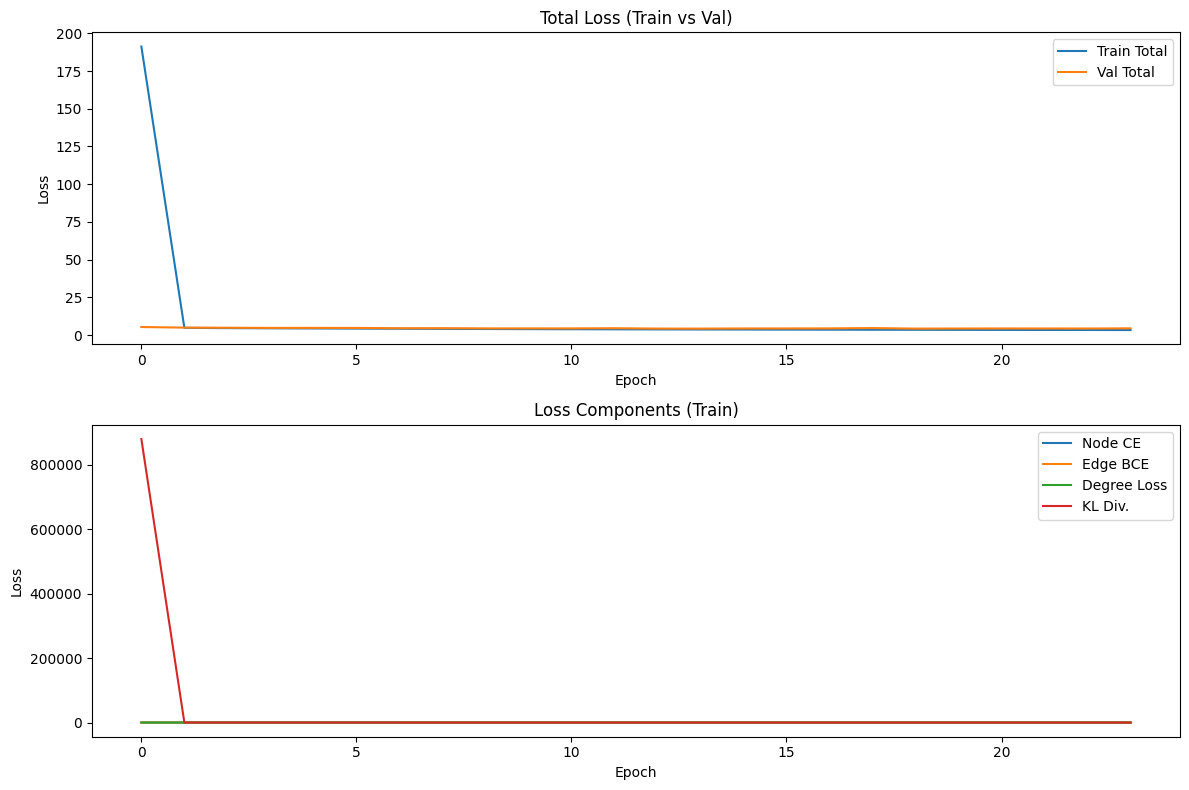

In [8]:
# Load best
model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
model.eval()

# ----------------------------
# Plot training curves
# ----------------------------
plt.figure(figsize=(12, 8))

# Total losses
plt.subplot(2, 1, 1)
plt.plot(hist['loss'], label='Train Total')
plt.plot(hist['val_loss'], label='Val Total')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Loss (Train vs Val)")
plt.legend()

# Component losses
plt.subplot(2, 1, 2)
plt.plot(hist['node'], label='Node CE')
plt.plot(hist['edge'], label='Edge BCE')
plt.plot(hist['deg'], label='Degree Loss')
plt.plot(hist['kld'], label='KL Div.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Components (Train)")
plt.legend()

plt.tight_layout()
plt.show()

Generated 32 valid molecules out of 32


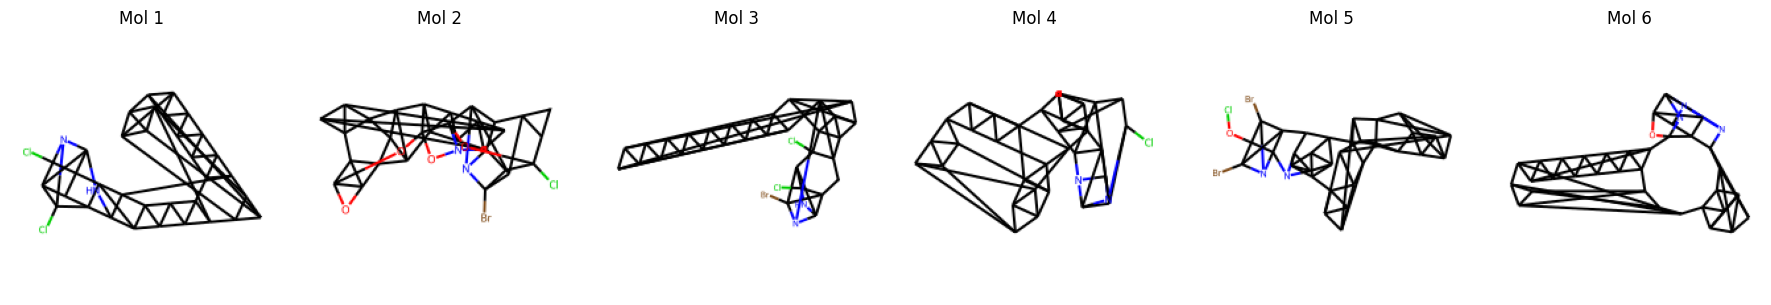

Validity: 100.00% | Novelty: 100.00% | Diversity: 76.74%
Avg similarity to train (max over first 500): 0.075


In [9]:
@torch.no_grad()
def sample_molecules(model, n: int, latent_dim: int, max_nodes: int) -> List[Chem.Mol]:
    z = torch.randn(n, latent_dim, device=DEVICE)
    node_logits, adj_logits = model.decode(z)
    node_probs = F.softmax(node_logits, dim=-1).cpu()
    adj_probs  = torch.sigmoid(adj_logits).cpu()

    mols = []
    for i in range(n):
        mol = greedy_valence_builder(node_probs[i], adj_probs[i])
        if mol is not None:
            try:
                Chem.SanitizeMol(mol)
                mols.append(mol)
            except Exception:
                pass
    return mols

# Generate
gen_mols = sample_molecules(model, n=32, latent_dim=LATENT_DIM, max_nodes=MAX_NODES)
print(f"Generated {len(gen_mols)} valid molecules out of 32")

# Visualize a few
if gen_mols:
    k = min(6, len(gen_mols))
    imgs = [Draw.MolToImage(m, size=(200,200), kekulize=True) for m in gen_mols[:k]]
    fig, axes = plt.subplots(1, k, figsize=(3*k, 3))
    if k == 1:
        axes = [axes]
    for ax, im, i in zip(axes, imgs, range(k)):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(f"Mol {i+1}")
    plt.tight_layout(); plt.show()

# ----------------------------
# Metrics: validity, novelty, diversity
# ----------------------------

morgan_gen = GetMorganGenerator(radius=2, fpSize=1024)

def mol_to_smiles_safe(m: Chem.Mol) -> str:
    try:
        return Chem.MolToSmiles(m)
    except Exception:
        return ""


def convert_training_molecule(data: Data) -> Chem.Mol:
    try:
        mol = Chem.RWMol()
        for i in range(data.x.shape[0]):
            idx = int(data.x[i].item())
            sym = ATOM_MAP.get(idx, 'C')
            mol.AddAtom(Chem.Atom(sym))
        edges = set()
        ei = data.edge_index.t().tolist()
        for u, v in ei:
            if u == v:
                continue
            a, b = (min(u,v), max(u,v))
            if (a,b) not in edges:
                mol.AddBond(int(a), int(b), Chem.BondType.SINGLE)
                edges.add((a,b))
        mol = mol.GetMol(); Chem.SanitizeMol(mol)
        return mol
    except Exception:
        return None


def calc_metrics(generated: List[Chem.Mol], train_set) -> Tuple[float,float,float]:
    # Validity already implied by sanitize; compute on attempted count
    attempted = 32
    validity = len(generated) / attempted if attempted > 0 else 0.0

    # Novelty vs. training
    train_smiles = set()
    for d in train_set[:2000]:  # speed
        m = convert_training_molecule(d)
        if m is not None:
            s = mol_to_smiles_safe(m)
            if s:
                train_smiles.add(s)

    novel = 0
    for m in generated:
        s = mol_to_smiles_safe(m)
        if s and (s not in train_smiles):
            novel += 1
    novelty = novel / max(1, len(generated))

    # Diversity: 1 - mean pairwise Tanimoto
    if len(generated) > 1:
        fps = [morgan_gen.GetFingerprint(m) for m in generated]
        sims = []
        for i in range(len(fps)):
            for j in range(i+1, len(fps)):
                sims.append(DataStructs.TanimotoSimilarity(fps[i], fps[j]))
        diversity = 1.0 - (np.mean(sims) if sims else 0.0)
    else:
        diversity = 0.0

    return validity, novelty, diversity

if gen_mols:
    val, nov, div = calc_metrics(gen_mols, train_dataset)
    print(f"Validity: {val:.2%} | Novelty: {nov:.2%} | Diversity: {div:.2%}")

    # Similarity to training set (quick look)
    train_mols = []
    for d in train_dataset[:500]:
        m = convert_training_molecule(d)
        if m is not None:
            train_mols.append(m)
    sims = []
    for gm in gen_mols:
        max_sim = 0.0
        fp_g = morgan_gen.GetFingerprint(gm)
        for tm in train_mols:
            sim = DataStructs.TanimotoSimilarity(fp_g, morgan_gen.GetFingerprint(tm))
            if sim > max_sim:
                max_sim = sim
        sims.append(max_sim)
    print(f"Avg similarity to train (max over first 500): {np.mean(sims):.3f}")

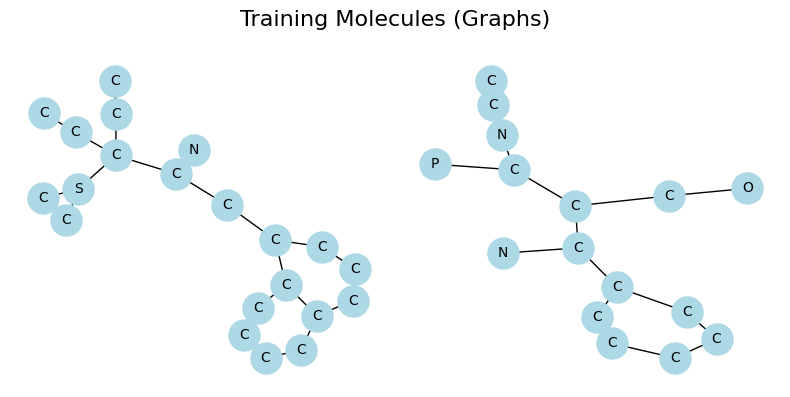

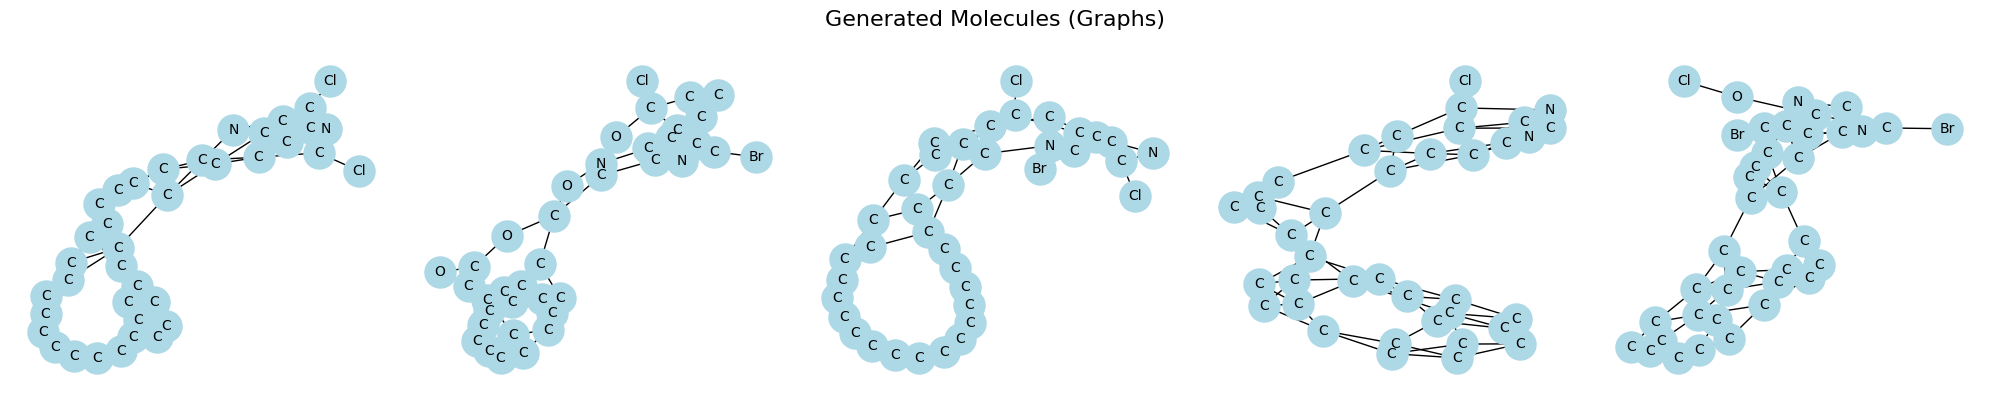

In [10]:
def mol_to_nx(mol: Chem.Mol) -> nx.Graph:
    """Convert RDKit Mol to a NetworkX graph."""
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), label=atom.GetSymbol())
    for bond in mol.GetBonds():
        a1, a2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        G.add_edge(a1, a2, bond_type=bond.GetBondType())
    return G

def plot_mol_graphs(mols, title: str, k: int = 5):
    """Plot k molecular graphs using networkx spring layout."""
    mols = [m for m in mols if m is not None][:k]
    fig, axes = plt.subplots(1, len(mols), figsize=(4*len(mols), 4))
    if len(mols) == 1:
        axes = [axes]
    for ax, mol in zip(axes, mols):
        G = mol_to_nx(mol)
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True,
                labels=nx.get_node_attributes(G, 'label'),
                node_color="lightblue", node_size=500,
                font_size=10, ax=ax)
        ax.set_axis_off()
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# -----------------------
# Compare training vs generated
# -----------------------
train_mols_for_plot = []
for d in train_dataset[:20]:  # collect some training molecules
    m = convert_training_molecule(d)
    if m is not None:
        train_mols_for_plot.append(m)

if train_mols_for_plot and gen_mols:
    plot_mol_graphs(train_mols_for_plot, title="Training Molecules (Graphs)", k=5)
    plot_mol_graphs(gen_mols, title="Generated Molecules (Graphs)", k=5)


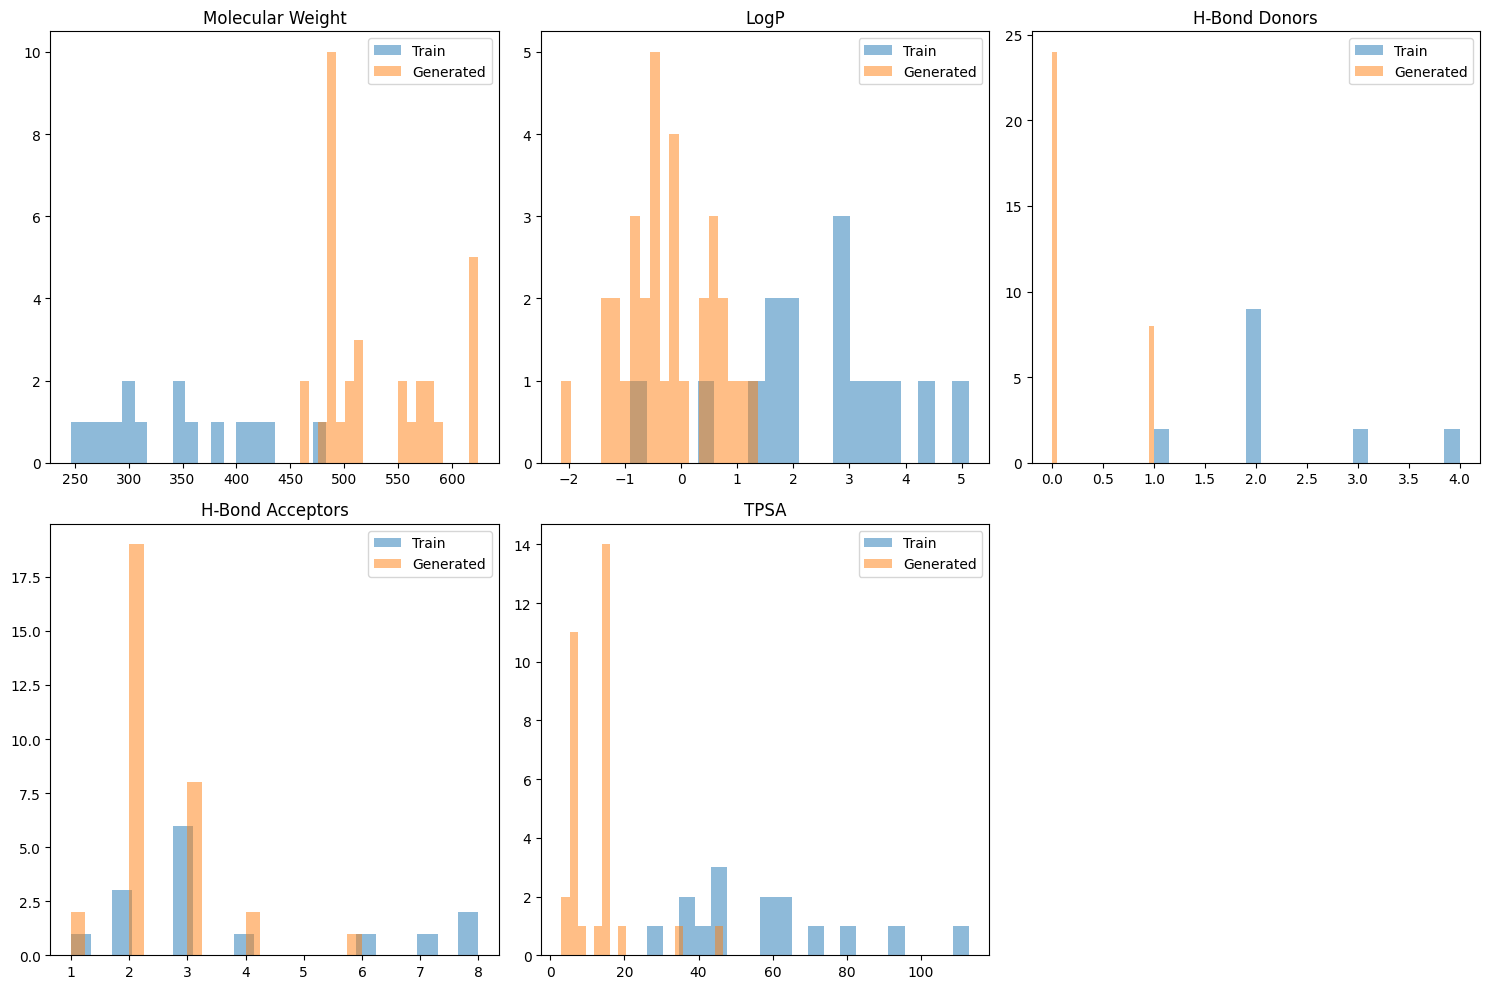


--- Model Report Card ---
Generated molecules: 32/32 valid
Validity: 100.00%
Novelty: 100.00%
Diversity: 76.74%
Train–Gen Mean Max Similarity: 0.067
-------------------------


In [11]:
# ----------------------------
# Analyze PhysChem Properties
# ----------------------------
def analyze_properties(molecules):
    properties = {
        'mw': [],   # Molecular weight
        'logp': [], # LogP
        'hbd': [],  # Hydrogen bond donors
        'hba': [],  # Hydrogen bond acceptors
        'tpsa': []  # Topological polar surface area
    }
    for mol in molecules:
        try:
            properties['mw'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['hbd'].append(Descriptors.NumHDonors(mol))
            properties['hba'].append(Descriptors.NumHAcceptors(mol))
            properties['tpsa'].append(Descriptors.TPSA(mol))
        except Exception:
            continue
    return properties

if gen_mols:
    # Convert some training molecules
    train_mols = []
    for d in train_dataset[:200]:
        m = convert_training_molecule(d)
        if m is not None:
            train_mols.append(m)

    # Compute properties
    train_props = analyze_properties(train_mols)
    gen_props = analyze_properties(gen_mols)

    # ----------------------------
    # Plot comparison histograms
    # ----------------------------
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    props = ['mw', 'logp', 'hbd', 'hba', 'tpsa']
    names = ['Molecular Weight', 'LogP', 'H-Bond Donors', 'H-Bond Acceptors', 'TPSA']

    for i, (prop, name) in enumerate(zip(props, names)):
        row, col = divmod(i, 3)
        if train_props[prop]:
            axes[row, col].hist(train_props[prop], bins=20, alpha=0.5, label="Train")
        if gen_props[prop]:
            axes[row, col].hist(gen_props[prop], bins=20, alpha=0.5, label="Generated")
        axes[row, col].set_title(name)
        axes[row, col].legend()

    # Remove empty subplot
    fig.delaxes(axes[1, 2])
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # Metrics: validity, novelty, diversity
    # ----------------------------
    attempted = 32
    validity = len(gen_mols) / attempted

    train_smiles = set()
    for m in train_mols:
        s = mol_to_smiles_safe(m)
        if s:
            train_smiles.add(s)

    novel = sum(1 for m in gen_mols if mol_to_smiles_safe(m) not in train_smiles)
    novelty = novel / len(gen_mols) if gen_mols else 0.0

    if len(gen_mols) > 1:
        fps = [morgan_gen.GetFingerprint(m) for m in gen_mols]
        sims = [DataStructs.TanimotoSimilarity(fps[i], fps[j])
                for i in range(len(fps)) for j in range(i+1, len(fps))]
        diversity = 1 - np.mean(sims) if sims else 0.0
    else:
        diversity = 0.0

    # ----------------------------
    # Train–Gen Similarity
    # ----------------------------
    sims = []
    for gm in gen_mols:
        fp_g = morgan_gen.GetFingerprint(gm)
        max_sim = max(DataStructs.TanimotoSimilarity(fp_g, morgan_gen.GetFingerprint(tm))
                      for tm in train_mols) if train_mols else 0.0
        sims.append(max_sim)

    mean_max_sim = np.mean(sims) if sims else 0.0

    # ----------------------------
    # Print Report Card
    # ----------------------------
    print("\n--- Model Report Card ---")
    print(f"Generated molecules: {len(gen_mols)}/{attempted} valid")
    print(f"Validity: {validity:.2%}")
    print(f"Novelty: {novelty:.2%}")
    print(f"Diversity: {diversity:.2%}")
    print(f"Train–Gen Mean Max Similarity: {mean_max_sim:.3f}")
    print("-------------------------")


In [12]:
# ----------------------------------------
# Similarity metrics: generated vs. training
# ----------------------------------------
def compute_similarity_metrics(gen_mols, train_mols, sample_train=1000):
    """Compute similarity statistics between generated and training molecules."""
    if not gen_mols or not train_mols:
        return {"MMS": 0.0, "MPS": 0.0}

    # Subsample training set for speed
    if len(train_mols) > sample_train:
        train_mols = np.random.choice(train_mols, sample_train, replace=False)

    fps_gen = [morgan_gen.GetFingerprint(m) for m in gen_mols]
    fps_train = [morgan_gen.GetFingerprint(m) for m in train_mols]

    # Mean maximum similarity (MMS)
    max_sims = []
    for fg in fps_gen:
        sims = DataStructs.BulkTanimotoSimilarity(fg, fps_train)
        max_sims.append(max(sims) if sims else 0.0)
    MMS = float(np.mean(max_sims))

    # Mean pairwise similarity (MPS) — sample if large
    sims = []
    for i, fg in enumerate(fps_gen):
        sims.extend(DataStructs.BulkTanimotoSimilarity(fg, fps_train))
    MPS = float(np.mean(sims)) if sims else 0.0

    return {"MMS": MMS, "MPS": MPS}

# Convert some training data to mols
train_mols = []
for d in train_dataset[:2000]:
    m = convert_training_molecule(d)
    if m is not None:
        train_mols.append(m)

if gen_mols and train_mols:
    sim_report = compute_similarity_metrics(gen_mols, train_mols)
    print("\n--- Train–Generated Similarity Report ---")
    print(f"Mean Max Similarity (MMS): {sim_report['MMS']:.3f}")
    print(f"Mean Pairwise Similarity (MPS): {sim_report['MPS']:.3f}")



--- Train–Generated Similarity Report ---
Mean Max Similarity (MMS): 0.084
Mean Pairwise Similarity (MPS): 0.033


# III. DiGress Lite

## 1. Data loading

In [ ]:
try:
    dataset
except NameError:
    from torch_geometric.datasets import ZINC
    dataset = ZINC(root='data/ZINC', subset=True, split='train')

try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Utils

To bridge between **graph neural networks (PyG)** and **chemistry toolkits (RDKit)**, we define helper functions that standardize atoms, bonds, and batching.

---

### 21. Atom Vocabulary & Valence Caps
- **`ATOM_TYPES`**: Defines the allowed atom symbols (`C, N, O, F, Cl, Br, I, P, S`).  
- **`ATOM_TO_IDX`**: Mapping from symbol → integer index for consistent encoding.  
- **`N_ATOM`**: Number of atom classes, used for embeddings.  
- **`MAX_VALENCE`**: Conservative limits for how many bonds each atom can form (helps detect invalid molecules).  

---

### 2.2. Graph → RDKit Conversion
**`graph_to_mol_safe(data)`**  
- Converts a PyG `Data` object into an RDKit `Mol`.  
- Steps:  
  1. Decode node features into atom symbols.  
  2. Add atoms to a `Chem.RWMol`.  
  3. Add bonds (single only, deduplicated).  
  4. Sanitize with RDKit to ensure validity.  
- **Robustness**: Wrapped in `try/except`, returning `None` if conversion fails.  

---

### 2.3. Data → Labels
**`data_to_labels_binary(d)`**  
- Extracts **discrete labels** for training:  
  - **Nodes**: integer atom indices (argmax over features).  
  - **Edges**: dense adjacency matrix (0 = no bond, 1 = bond).  
- Ensures labels remain inside the valid atom vocabulary.  

---

### 2.4. Batch Padding
**`pad_batch(label_list)`**  
- Prepares variable-sized molecules for minibatch training.  
- Pads node and edge labels to the max graph size in the batch.  
- Uses special **MASK IDs**:  
  - Node mask = `N_ATOM`.  
  - Edge mask = `2`.  
- Returns:
  - `nodes`: `(B, Nmax)` tensor of node labels.  
  - `edges`: `(B, Nmax, Nmax)` tensor of edge labels.  
  - `n_valid`: number of valid atoms per molecule.  

---

**Summary:**  
These utilities provide the **glue layer** between molecule graphs, neural network inputs, and chemistry validation. They ensure consistent atom indexing, safe graph→molecule conversion, and padded batching for efficient GPU training.

In [ ]:
# Atom vocabulary you used earlier (keeps evaluation consistent)
ATOM_TYPES = ['C','N','O','F','Cl','Br','I','P','S']
ATOM_TO_IDX = {a:i for i,a in enumerate(ATOM_TYPES)}
N_ATOM = len(ATOM_TYPES)

# Approximate valence caps (kept conservative to avoid invalids)
MAX_VALENCE = {'H':1, 'C':4, 'N':3, 'O':2, 'F':1, 'Cl':1, 'Br':1, 'I':1, 'P':5, 'S':6}

# === Graph -> RDKit safe conversion (single bonds) ===
def graph_to_mol_safe(data):
    try:
        if data.x is None or data.x.shape[0] == 0: return None
        N = int(data.x.shape[0])
        atom_symbols = []
        for i in range(N):
            row = data.x[i]
            arr = row.detach().cpu().numpy() if isinstance(row, torch.Tensor) else np.asarray(row)
            idx = int(np.argmax(arr))
            atom_symbols.append(ATOM_TYPES[idx] if idx < len(ATOM_TYPES) else 'C')

        mol = Chem.RWMol()
        for sym in atom_symbols:
            mol.AddAtom(Chem.Atom(sym))

        if data.edge_index is not None and data.edge_index.numel() > 0:
            ei = data.edge_index
            if isinstance(ei, torch.Tensor): ei = ei.cpu().numpy()
            pairs = set()
            for a,b in zip(ei[0].tolist(), ei[1].tolist()):
                if a==b: continue
                u,v = (a,b) if a<b else (b,a)
                pairs.add((u,v))
            for (u,v) in pairs:
                if u < N and v < N:
                    try: mol.AddBond(int(u), int(v), Chem.BondType.SINGLE)
                    except: pass

        mol = mol.GetMol()
        Chem.SanitizeMol(mol)
        return mol
    except Exception:
        return None

# === Build node/edge labels from PyG Data (binary edges: 0=no bond, 1=bond) ===
def data_to_labels_binary(d: Data, clamp_atom_vocab=True):
    # Node labels from argmax over features (fallback -> C)
    x = d.x
    n = int(x.size(0))
    node_lbl = x.argmax(dim=-1).long()
    if clamp_atom_vocab:
        node_lbl = node_lbl.clamp(min=0, max=N_ATOM-1)
    # Dense edge labels (n x n), 0=none, 1=bond (ignore diagonal)
    E = torch.zeros((n, n), dtype=torch.long)
    if d.edge_index is not None and d.edge_index.numel() > 0:
        ei = d.edge_index
        for k in range(ei.size(1)):
            u = int(ei[0, k]); v = int(ei[1, k])
            if u==v: continue
            E[u, v] = 1; E[v, u] = 1
    for i in range(n): E[i,i] = 0
    return node_lbl, E

# === pad to batch tensors ===
def pad_batch(label_list):
    # list of (node_lbl[n], edge_lbl[n,n])
    max_n = max(l[0].numel() for l in label_list)
    B = len(label_list)
    nodes = torch.full((B, max_n), N_ATOM, dtype=torch.long)         # extra MASK id = N_ATOM
    edges = torch.full((B, max_n, max_n), 2, dtype=torch.long)       # edge classes: 0/1 + MASK=2
    n_valid = torch.zeros(B, dtype=torch.long)
    for b,(nl,El) in enumerate(label_list):
        n = nl.numel()
        nodes[b,:n] = nl
        edges[b,:n,:n] = El
        for i in range(n): edges[b,i,i] = 0
        n_valid[b] = n
    return nodes, edges, n_valid

### 3. DiGress-Lite: Architecture

**DiGress-Lite** is a simplified graph diffusion model that generates molecules by **iteratively denoising masked atoms and bonds**.  
Instead of reconstructing the entire molecule at once, it learns to gradually fill in missing pieces.

---

#### 3.1. Model Architecture

- **DiffBlock**  
  - Residual MLP block with LayerNorm, GELU, and dropout.  
  - Aggregates node features with neighbor information.  

- **Node & Edge Embeddings**  
  - Nodes: `N_ATOM + 1` classes (atoms + mask).  
  - Edges: 2 bond states (bond/no bond) + mask.  
  - Learned embeddings for atoms, bonds, and timestep `t`.  

- **Message Passing**  
  - Soft adjacency derived from current edge tokens.  
  - Neighbors’ hidden states are aggregated and passed through stacked DiffBlocks.  

- **Prediction Heads**  
  - Node head: predicts atom types for masked nodes.  
  - Edge head: predicts bond presence for masked pairs.  

---

#### 3.2. Noise Schedule & Training

- **MaskScheduler**  
  - Linearly increases masking probability for nodes and edges over `T` steps.  
  - Early timesteps: few tokens masked → easy denoising.  
  - Later timesteps: most tokens masked → harder predictions.  

- **Training Process**  
  1. Randomly mask a fraction of atom and bond tokens.  
  2. Input the noisy graph and timestep embedding into the denoiser.  
  3. Compute cross-entropy loss only on the masked positions.  
  4. Update parameters with AdamW optimization.  

---

#### 3.3. Pros and Cons

**Pros**
- Stable training (no GAN collapse, no KL balancing).  
- Naturally handles discrete atoms and bonds.  
- Encourages diversity and smooth exploration of chemical space.  
- Time-step conditioning enables gradual refinement.  

**Cons**
- Sampling is slow (many denoising steps).  
- Current version only models binary bonds (no stereochemistry).  
- Validity not guaranteed without post-processing.  
- Requires larger datasets for full benefit.  

---

#### 3.4. Loss Function

The training objective is based on **masked token prediction**, similar to BERT:

- **Node Loss (Atoms)**  
  - When nodes are masked, the model predicts their atom type.  
  - Loss: cross-entropy between predicted logits and ground-truth atom types.  
  - Only masked nodes contribute.  

- **Edge Loss (Bonds)**  
  - When edges are masked, the model predicts bond presence (bond vs no bond).  
  - Loss: cross-entropy between predicted logits and ground-truth edge labels.  
  - Only masked edges contribute (diagonal excluded).  

- **Total Loss**  
  \[
  \mathcal{L} = \mathcal{L}_{node} + \mathcal{L}_{edge}
  \]

- **Training Dynamics**  
  - Early steps: few masks, model learns local corrections.  
  - Later steps: many masks, model learns global structure recovery.  

**Key Insight:**  
The loss is **sparse and adaptive**, only focusing on the corrupted tokens. This forces the model to *impute missing chemistry* instead of copying unmasked regions, making diffusion-based denoising stable and effective for molecule generation.  


In [4]:
# =========================
# 2) DiGress-lite model
# =========================
class DiffBlock(nn.Module):
    def __init__(self, d=128, dropout=0.0):
        super().__init__()
        self.lin1 = nn.Linear(d, d); self.lin2 = nn.Linear(d, d)
        self.act = nn.GELU(); self.do = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d)
    def forward(self, h):
        x = self.lin2(self.act(self.lin1(h)))
        return self.norm(h + self.do(x))

class DiGressLite(nn.Module):
    """
    Simple denoiser: node token embeddings + edge-aware message via soft adjacency, then MLP heads.
    Node classes: N_ATOM + 1(MASK); Edge classes: 2 (no/yes) + 1(MASK).
    """
    def __init__(self, d=128, L=6, dropout=0.0):
        super().__init__()
        self.node_vocab = N_ATOM + 1
        self.edge_vocab = 2 + 1
        self.d = d
        self.node_emb = nn.Embedding(self.node_vocab, d)
        self.edge_emb = nn.Embedding(self.edge_vocab, d)
        self.t_emb = nn.Embedding(128, d)  # time embedding for small T
        self.blocks = nn.ModuleList([DiffBlock(d, dropout) for _ in range(L)])
        self.to_node = nn.Sequential(nn.LayerNorm(d), nn.Linear(d, N_ATOM))
        self.to_edge = nn.Sequential(nn.LayerNorm(d), nn.Linear(d, 2))
    def forward(self, node_toks, edge_toks, n_valid, t_idx):
        """
        node_toks: (B,N) in [0..N_ATOM] where N_ATOM==MASK
        edge_toks: (B,N,N) in {0,1,2} where 2==MASK
        """
        B,N = node_toks.size()
        h = self.node_emb(node_toks) + self.t_emb(t_idx).unsqueeze(1)  # (B,N,d)
        # soft adjacency as weights from edge tokens (0=no,1=bond,2=mask->0)
        w = (edge_toks == 1).float()  # (B,N,N)
        w = w / (w.sum(-1, keepdim=True) + 1e-6)
        for blk in self.blocks:
            m = torch.matmul(w, h)              # (B,N,d) aggregated neighbors
            h = blk(h + m)                      # residual with neighbor info
        node_logits = self.to_node(h)           # (B,N,N_ATOM)
        # edge head: score for "bond" vs "no bond" per pair using pair features
        hi = h.unsqueeze(2).expand(B, N, N, self.d)
        hj = h.unsqueeze(1).expand(B, N, N, self.d)
        hp = hi + hj
        edge_logits = self.to_edge(hp)          # (B,N,N,2)
        # zero diagonal
        eye = torch.eye(N, dtype=torch.bool, device=h.device).unsqueeze(0).unsqueeze(-1)
        edge_logits = edge_logits.masked_fill(eye, -1e9)
        return node_logits, edge_logits

# =========================
# 3) Noise schedule & training
# =========================
class MaskScheduler:
    def __init__(self, T=50, p_node=(0.10, 0.95), p_edge=(0.05, 0.90)):
        self.T = T
        self.pn0, self.pnT = p_node
        self.pe0, self.peT = p_edge
    def p_node_t(self, t):  # linear
        return self.pn0 + (self.pnT - self.pn0) * t / (self.T-1)
    def p_edge_t(self, t):
        return self.pe0 + (self.peT - self.pe0) * t / (self.T-1)

def corrupt(nodes, edges, n_valid, pnode, pedge):
    """
    Randomly mask a fraction of nodes/edges. MASK ids: node=N_ATOM, edge=2.
    """
    B,N = nodes.size()
    nodes_noisy = nodes.clone()
    edges_noisy = edges.clone()
    node_mask = torch.zeros_like(nodes_noisy, dtype=torch.bool)
    edge_mask = torch.zeros_like(edges_noisy, dtype=torch.bool)
    for b in range(B):
        n = int(n_valid[b].item())
        if n == 0: continue
        k_node = max(1, int(round(pnode * n)))
        idx = torch.randperm(n, device=nodes.device)[:k_node]
        node_mask[b, idx] = True
        nodes_noisy[b, idx] = N_ATOM
        # edges
        k_edge = max(1, int(round(pedge * (n*(n-1)//2))))
        pairs = [(i,j) for i in range(n) for j in range(i+1,n)]
        sel = random.sample(pairs, k=min(k_edge, len(pairs)))
        for (i,j) in sel:
            edge_mask[b,i,j] = True; edge_mask[b,j,i] = True
            edges_noisy[b,i,j] = 2; edges_noisy[b,j,i] = 2
        for i in range(n): edges_noisy[b,i,i]=0
    return nodes_noisy, edges_noisy, node_mask, edge_mask

# batchify dataset
def make_batch(ds, batch_size=64):
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    for batch in loader:
        label_list = []
        for d in batch.to_data_list():
            nl, El = data_to_labels_binary(d)
            label_list.append((nl, El))
        nodes, edges, n_valid = pad_batch(label_list)
        yield nodes.to(device), edges.to(device), n_valid.to(device)

# =========================
# 4) Train denoiser
# =========================
cfg = dict(d=128, L=6, dropout=0.0, T=50, epochs=10, bs=64, lr=2e-3, wd=1e-4)
model = DiGressLite(d=cfg['d'], L=cfg['L'], dropout=cfg['dropout']).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
sched = MaskScheduler(T=cfg['T'])

print(">> Training DiGress-lite (discrete diffusion)...")
model.train()
for epoch in range(1, cfg['epochs']+1):
    tot, tot_node, tot_edge, nb = 0.0, 0.0, 0.0, 0
    for nodes_gt, edges_gt, n_valid in make_batch(dataset, batch_size=cfg['bs']):
        # pick a timestep
        t = torch.randint(0, sched.T, (1,), device=device).item()
        pn, pe = sched.p_node_t(t), sched.p_edge_t(t)
        nodes_in, edges_in, nmask, emask = corrupt(nodes_gt, edges_gt, n_valid, pn, pe)
        t_idx = torch.full((nodes_gt.size(0),), t, dtype=torch.long, device=device)

        # forward
        node_logits, edge_logits = model(nodes_in, edges_in, n_valid, t_idx)
        # compute CE only on masked entries (and only on valid node region)
        loss_node = []
        loss_edge = []
        B,N = nodes_gt.size()
        for b in range(B):
            n = int(n_valid[b].item())
            if n == 0: continue
            # nodes
            mask_b = nmask[b,:n]
            if mask_b.any():
                ln = F.cross_entropy(node_logits[b,:n][mask_b], nodes_gt[b,:n][mask_b], reduction='mean')
                loss_node.append(ln)
            # edges
            mask_e = emask[b,:n,:n]
            if mask_e.any():
                # logits: (n,n,2) -> select masked pairs
                logits_e = edge_logits[b,:n,:n][mask_e]
                target_e = edges_gt[b,:n,:n][mask_e].clamp(0,1)
                le = F.cross_entropy(logits_e, target_e, reduction='mean')
                loss_edge.append(le)
        ln = torch.stack(loss_node).mean() if len(loss_node) > 0 else torch.tensor(0., device=device)
        le = torch.stack(loss_edge).mean() if len(loss_edge) > 0 else torch.tensor(0., device=device)
        loss = ln + le

        opt.zero_grad()
        loss.backward()
        opt.step()

        tot += float(loss.item()); tot_node += float(ln.item()); tot_edge += float(le.item()); nb += 1
    print(f"[ep {epoch:02d}] loss={tot/max(1,nb):.4f} (node {tot_node/max(1,nb):.4f} | edge {tot_edge/max(1,nb):.4f})")

>> Training DiGress-lite (discrete diffusion)...
[ep 01] loss=0.3459 (node 0.0197 | edge 0.3262)
[ep 02] loss=0.3215 (node 0.0003 | edge 0.3213)
[ep 03] loss=0.3187 (node 0.0001 | edge 0.3186)
[ep 04] loss=0.3201 (node 0.0001 | edge 0.3200)
[ep 05] loss=0.3184 (node 0.0001 | edge 0.3183)
[ep 06] loss=0.3168 (node 0.0000 | edge 0.3167)
[ep 07] loss=0.3160 (node 0.0000 | edge 0.3160)
[ep 08] loss=0.3158 (node 0.0000 | edge 0.3158)
[ep 09] loss=0.3142 (node 0.0000 | edge 0.3142)
[ep 10] loss=0.3146 (node 0.0000 | edge 0.3145)


## 4. Generation, Evaluation, and Molecular Property Analysis

This section turns a trained **DiGress-Lite** denoiser into a practical molecule generator and evaluator. It covers (a) how we sample graphs with simple chemistry constraints, (b) how we score sets of molecules, and (c) how we visualize what we got.

---

### 4.1. Helpers & Result Hygiene

- **`_to_py_float` / `pretty_metrics`**  
  Small utilities to convert NumPy scalars (e.g., `np.float64`) into native Python types. This avoids awkward printing/serialization issues and makes logs, JSON dumps, or progress bars cleaner.

---

### 4.2. Diversity-Aware Selection

- **`select_diverse_subset` (greedy max-min)**  
  Operates on **Morgan fingerprints** to pick a subset of molecules that are **as far apart as possible** under Tanimoto distance.  
  - **Mode A (fixed size `k`)**: greedily adds the molecule that maximizes the **minimum** distance to the current set.  
  - **Mode B (`min_dist`)**: keeps only molecules that are at least `min_dist` away from those already chosen.  
  Use this to down-select a **diverse panel** for docking, property prediction, or human inspection.

---

### 4.3. Valence-Aware Sampling (Discrete Diffusion Decoding)

- **Idea:** Start from a **fully masked graph** and iteratively unmask nodes and edges for `T` steps, each time conditioning on the current partially unmasked structure.
- **Node updates:**  
  Masked nodes receive a categorical distribution over atom types from the denoiser; we **sample** an atom type and update a **per-node valence cap** using a simple lookup (e.g., C=4, N=3, O=2, …).
- **Edge proposals:**  
  For masked pairs `(i, j)`, take the model’s **bond logits**, sort by confidence, and **accept** bonds **only** if both endpoints won’t exceed their valence caps (track degree during decoding). Diagonal/self-loops are disabled; symmetry is enforced.
- **Top-K pruning (optional):**  
  To save time and avoid dense graphs, keep only the top-K edge proposals at each step.
- **Why this works:**  
  It combines the **stability** of masked diffusion with a **lightweight chemistry prior** (valence), lifting validity without expensive constraint solvers.

---

### 4.4. Graph ↔ Molecule Conversion

- **`labels_to_pyg`** builds PyG graphs (one-hot atom features + undirected edge list) from decoded labels.  
- **`graph_to_mol_safe`** converts a PyG graph to an RDKit molecule (single bonds in this lite variant) and runs **RDKit sanitization**. This acts as a basic validity check.

---

### 4.5. Metrics

- **Validity**: fraction of generated graphs that RDKit can sanitize.  
- **Uniqueness**: fraction of *valid* molecules with unique SMILES within the generated set.  
- **Novelty**: fraction of *valid* molecules not appearing in the training set (SMILES comparison).  
- **Diversity**: `1 − mean(Tanimoto)` over Morgan fingerprints of the generated set (higher = more diverse).

> These four metrics together capture **chemical feasibility**, **non-duplication**, **non-memorization**, and **spread** in chemical space.

---

### 4.6. Property & Similarity Analyses

- **PhysChem histograms** (`MW`, `LogP`, `HBD`, `HBA`, `TPSA`):  
  Compare distributions between **generated** and **training** sets to check for **distributional shift** (mode collapse vs. unrealistic tails).
- **Similarity to Training**:  
  For each generated molecule, compute **max Tanimoto similarity** to a pool of training molecules; plot a histogram.  
  - **Low values** → stronger novelty/less memorization.  
  - **A healthy tail** may still be desirable if you want to stay close to the training domain.

- **Grids & raw graphs**:  
  - **Molecule grid** (RDKit): quick visual sanity check for ring systems, branching, and obvious errors.  
  - **Raw graph sketches** (NetworkX): useful when RDKit rendering fails or when debugging graph topology.

---

### 4.7. End-to-End Flow

1. **Sample** with valence-aware masking for `num_samples` graphs (choose `T`, `topk_edges`, and `max_nodes`).  
2. **Convert** labels → PyG graphs → RDKit molecules (sanitize).  
3. **Evaluate**: compute validity, uniqueness, novelty, and diversity (return a clean dict via `pretty_metrics`).  
4. **Visualize**: grid of molecules, property histograms vs. training, similarity histogram.  
5. **(Optional)** **Subselect** a **diverse** subset with `select_diverse_subset` for downstream tasks.

---

### 4.8. Interpreting Example Results

Example (from a 64-sample run):

- **Metrics:** `{'validity': 100%, 'uniqueness': 34.4%, 'novelty': 100%, 'diversity': ~50%}`  
  - *Validity 100%*: valence-aware decoding + sanitization are doing their job.  
  - *Novelty 100%*: no training duplicates—good for exploration.  
  - *Uniqueness 34.4%*: many near-duplicates were decoded; consider increasing `min_dist` in selection or adjusting decoding temperature/top-K.  
  - *Diversity ~0.50%*: reasonable spread; can be boosted with stronger masking later in diffusion steps or by seeding with different random starts.

---

### 4.9. Practical Tips

- **Sampling time vs. quality**: Larger `T` and moderate `topk_edges` usually increase validity/diversity but slow down generation.  
- **Valence caps**: Conservative caps reduce obvious invalids; relax with care if you add multiple bond types.  
- **Dataset coverage**: More training data typically improves structure recovery at high mask ratios and yields richer chemical space.  
- **Fingerprint settings**: Keep **radius=2, fp=1024** for comparability with literature; adjust only if you have a domain-specific reason.

---

### 4.10. Takeaway

This generation stack pairs **discrete diffusion** with **light chemistry constraints** and **robust evaluation**. It’s simple, stable, and extensible—ready to plug into docking, QSAR triage, or reinforcement-learning reranking pipelines.


In [9]:
def _to_py_float(x):
    try:
        return float(x)
    except Exception:
        return x

def pretty_metrics(mdict):
    return {k: _to_py_float(v) for k, v in mdict.items()}

In [10]:
def select_diverse_subset(mols, k=None, min_dist=None, fp_size=1024, radius=2, seed=0):
    """
    Greedy max-min over Morgan fingerprints.
    - If min_dist is provided (0..1), keep as many as possible with Tanimoto <= 1-min_dist.
    - Else pick exactly k (defaults to len(mols)) maximizing diversity.
    """
    if not mols: return []
    gen = GetMorganGenerator(radius=radius, fpSize=fp_size)
    fps = [gen.GetFingerprint(m) for m in mols]
    N = len(fps)

    rng = np.random.RandomState(seed)
    start = rng.randint(0, N)
    picked = [start]
    D = np.ones(N) * 1e9
    for i in range(N):
        if i == start: D[i] = 0.0
        else:
            D[i] = 1.0 - DataStructs.TanimotoSimilarity(fps[start], fps[i])

    target = (k if k is not None else N)
    while len(picked) < target:
        nxt = int(np.argmax(D))
        if D[nxt] <= 0: break
        picked.append(nxt)
        for i in range(N):
            d = 1.0 - DataStructs.TanimotoSimilarity(fps[nxt], fps[i])
            if d > D[i]: D[i] = d

    if min_dist is not None:
        # keep only those that are at least 'min_dist' away from previous picks
        kept = []
        kept_fps = []
        for idx in picked:
            f = fps[idx]
            if all((1.0 - DataStructs.TanimotoSimilarity(f, g)) >= min_dist for g in kept_fps):
                kept.append(idx); kept_fps.append(f)
        return kept

    return picked

In [11]:
# =========================
# 5) Sampling with valence-aware masking
# =========================
def sample_valence_aware(batch_size=64, max_nodes=38, T=None, topk_edges=None, seed=0):
    """
    Iterative unmasking: start fully masked and fill tokens over T steps.
    Edge labels are binary (0/1). Enforces degree <= typical valence cap.
    """
    model.eval()
    rng = torch.Generator(device="cpu"); rng.manual_seed(seed)
    T = T or sched.T
    outs = []
    for b in range(batch_size):
        n = int(torch.randint(low=5, high=min(max_nodes, 28), size=(1,), generator=rng).item())  # ZINC small graphs
        node_lbl = torch.full((1, n), N_ATOM, dtype=torch.long, device=device)    # MASK
        edge_lbl = torch.full((1, n, n), 2, dtype=torch.long, device=device)      # MASK
        for i in range(n): edge_lbl[0,i,i] = 0

        # track valence/degree during decoding
        cur_deg = torch.zeros(n, dtype=torch.long, device=device)
        max_val = torch.full((n,), 4, dtype=torch.long, device=device)

        for t in range(T):
            t_idx = torch.full((1,), T-1-t, dtype=torch.long, device=device)
            nl, el = model(node_lbl, edge_lbl, torch.tensor([n], device=device), t_idx)

            # ----- pick node classes for masked only -----
            mask_nodes = (node_lbl == N_ATOM)[0]    # (n,)
            if mask_nodes.any():
                probs = F.softmax(nl[0, mask_nodes], dim=-1)
                samp = torch.multinomial(probs, 1).squeeze(-1)
                node_lbl[0, mask_nodes] = samp
                # update node valence caps
                for i_idx, i in enumerate(torch.nonzero(mask_nodes, as_tuple=False).view(-1)):
                    sym = ATOM_TYPES[int(samp[i_idx].item())] if int(samp[i_idx].item()) < len(ATOM_TYPES) else 'C'
                    max_val[i] = MAX_VALENCE.get(sym, 4)

            # ----- edge proposals only between currently masked edges -----
            mask_edges = (edge_lbl == 2)[0]   # (n,n)
            if mask_edges.any():
                # logits for "bond" class 1 vs 0
                logit_bond = el[0,:,:,1]  # (n,n)
                # symmetry & no self-loop
                logit_bond = (logit_bond + logit_bond.T) * 0.5
                logit_bond.fill_diagonal_(-1e9)

                # build candidate list sorted by confidence
                idxs = torch.nonzero(mask_edges & (~torch.eye(n, dtype=torch.bool, device=device)), as_tuple=False)
                scores = logit_bond[idxs[:,0], idxs[:,1]]
                # take upper triangle only
                keep = idxs[:,0] < idxs[:,1]
                idxs = idxs[keep]; scores = scores[keep]
                if idxs.numel() > 0:
                    order = torch.argsort(scores, descending=True)
                    idxs = idxs[order]
                    # optional topk pruning
                    if topk_edges is not None and idxs.size(0) > topk_edges:
                        idxs = idxs[:topk_edges]

                    # valence-aware accept/reject
                    for k in range(idxs.size(0)):
                        i,j = int(idxs[k,0].item()), int(idxs[k,1].item())
                        # don’t exceed valence caps
                        if cur_deg[i] + 1 <= max_val[i] and cur_deg[j] + 1 <= max_val[j]:
                            edge_lbl[0,i,j] = 1; edge_lbl[0,j,i] = 1
                            cur_deg[i] += 1; cur_deg[j] += 1
                        else:
                            edge_lbl[0,i,j] = 0; edge_lbl[0,j,i] = 0

            # progressively unmask remaining fraction
            # (here we simply leave non-updated entries masked; the next step will try again)

        outs.append((node_lbl[0].detach().cpu(), edge_lbl[0].detach().cpu()))
    return outs

def labels_to_pyg(samples):
    graphs = []
    for nl, E in samples:
        n = int(nl.numel())
        x = torch.zeros(n, N_ATOM, dtype=torch.float32)
        for i in range(n):
            idx = int(nl[i].item());
            if idx >= N_ATOM: idx = 0
            x[i, idx] = 1.0
        edges = []
        for i in range(n):
            for j in range(i+1, n):
                if int(E[i,j].item()) == 1:
                    edges.append([i,j]); edges.append([j,i])
        if len(edges) > 0:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2,0), dtype=torch.long)
        graphs.append(Data(x=x, edge_index=edge_index))
    return graphs

# =========================
# 6) Evaluation & visualization (same metrics/plots you used)
# =========================
def analyze_properties(molecules):
    props = dict(mw=[], logp=[], hbd=[], hba=[], tpsa=[])
    for mol in molecules:
        props['mw'].append(Descriptors.MolWt(mol))
        props['logp'].append(Descriptors.MolLogP(mol))
        props['hbd'].append(Descriptors.NumHDonors(mol))
        props['hba'].append(Descriptors.NumHAcceptors(mol))
        props['tpsa'].append(Descriptors.TPSA(mol))
    return props

def evaluate_set(graphs, train_set):
    # validity + smiles + RDKit mols
    mols, smiles = [], []
    for g in graphs:
        m = graph_to_mol_safe(g)
        if m is not None:
            try:
                Chem.SanitizeMol(m)
                s = Chem.MolToSmiles(m)
                mols.append(m); smiles.append(s)
            except: pass
    validity = len(mols) / max(1,len(graphs))
    # uniqueness
    uniq = len(set(smiles)) / max(1,len(smiles))
    # novelty vs train
    train_smiles = set()
    for d in train_set[:5000]:  # subset for speed
        m = graph_to_mol_safe(d)
        if m is None: continue
        try: train_smiles.add(Chem.MolToSmiles(m))
        except: pass
    novelty = np.mean([s not in train_smiles for s in smiles]) if smiles else 0.0
    # diversity (1 - mean pairwise Tanimoto)
    if len(mols) > 1:
        gen = GetMorganGenerator(radius=2, fpSize=1024)
        fps = [gen.GetFingerprint(m) for m in mols]
        sims = []
        for i in range(len(fps)):
            for j in range(i+1,len(fps)):
                sims.append(DataStructs.TanimotoSimilarity(fps[i], fps[j]))
        diversity = 1 - float(np.mean(sims)) if len(sims)>0 else 0.0
    else:
        diversity = 0.0
    return dict(validity=validity, uniqueness=uniq, novelty=novelty, diversity=diversity), mols, smiles

def show_mol_grid(mols, max_mols=32, title="Generated molecules"):
    if not mols:
        print("No valid molecules to display.")
        return

    k = min(max_mols, len(mols))

    # Try to draw without kekulization (avoids ring-perception warnings)
    try:
        img = Draw.MolsToGridImage(
            mols[:k],
            molsPerRow=8,
            subImgSize=(220, 220),
            useSVG=False,       # returns a PIL Image
            kekulize=False      # <- important to avoid ring warnings while drawing
        )
        # Ensure RGB then convert to ndarray[uint8] for matplotlib
        if hasattr(img, "mode") and img.mode != "RGB":
            img = img.convert("RGB")
        arr = np.asarray(img)   # uint8 array
        plt.figure(figsize=(16, 8))
        plt.imshow(arr)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except Exception as e:
        # Fallback: render as SVG in notebooks (if PIL backend hiccups)
        try:
            svg = Draw.MolsToGridImage(
                mols[:k],
                molsPerRow=8,
                subImgSize=(220, 220),
                useSVG=True,
                kekulize=False
            )
            from IPython.display import SVG, display
            display(SVG(svg))
        except Exception as e2:
            print(f"Could not render grid: {e} / {e2}")


Metrics: {'validity': 1.0, 'uniqueness': 0.34375, 'novelty': np.float64(1.0), 'diversity': 0.5001231049594145}
Could not render grid: Python argument types in
    MolDraw2D.DrawMolecules(MolDraw2DCairo, list)
did not match C++ signature:
    DrawMolecules(RDKit::MolDraw2D {lvalue} self, boost::python::api::object mols, boost::python::api::object highlightAtoms=None, boost::python::api::object highlightBonds=None, boost::python::api::object highlightAtomColors=None, boost::python::api::object highlightBondColors=None, boost::python::api::object highlightAtomRadii=None, boost::python::api::object confIds=None, boost::python::api::object legends=None) / Python argument types in
    MolDraw2D.DrawMolecules(MolDraw2DSVG, list)
did not match C++ signature:
    DrawMolecules(RDKit::MolDraw2D {lvalue} self, boost::python::api::object mols, boost::python::api::object highlightAtoms=None, boost::python::api::object highlightBonds=None, boost::python::api::object highlightAtomColors=None, boost::

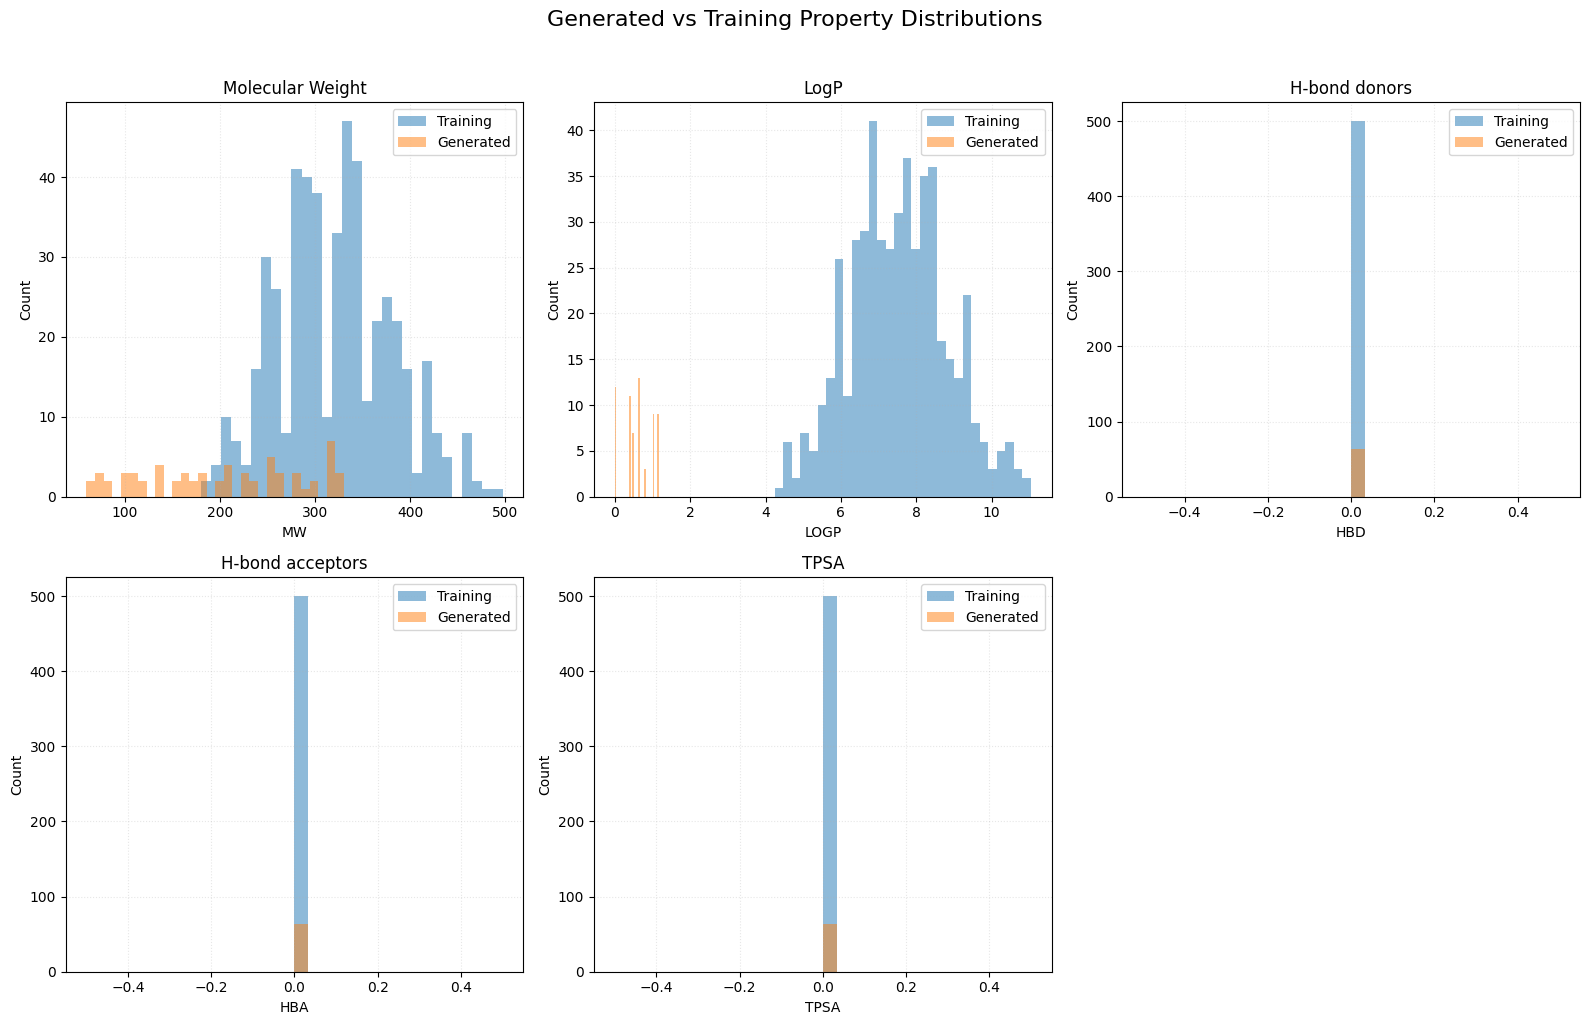

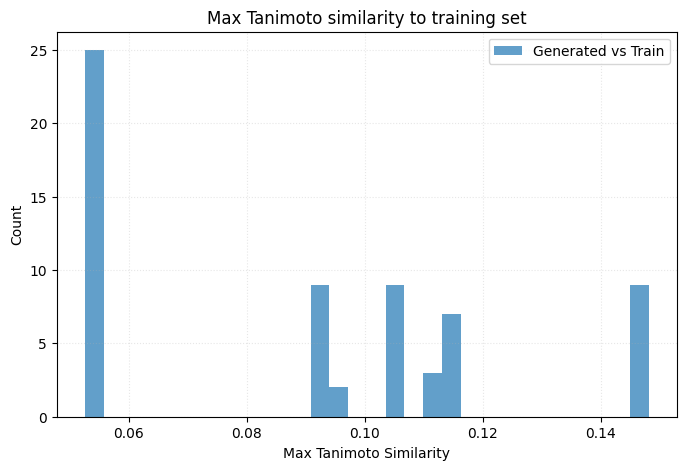

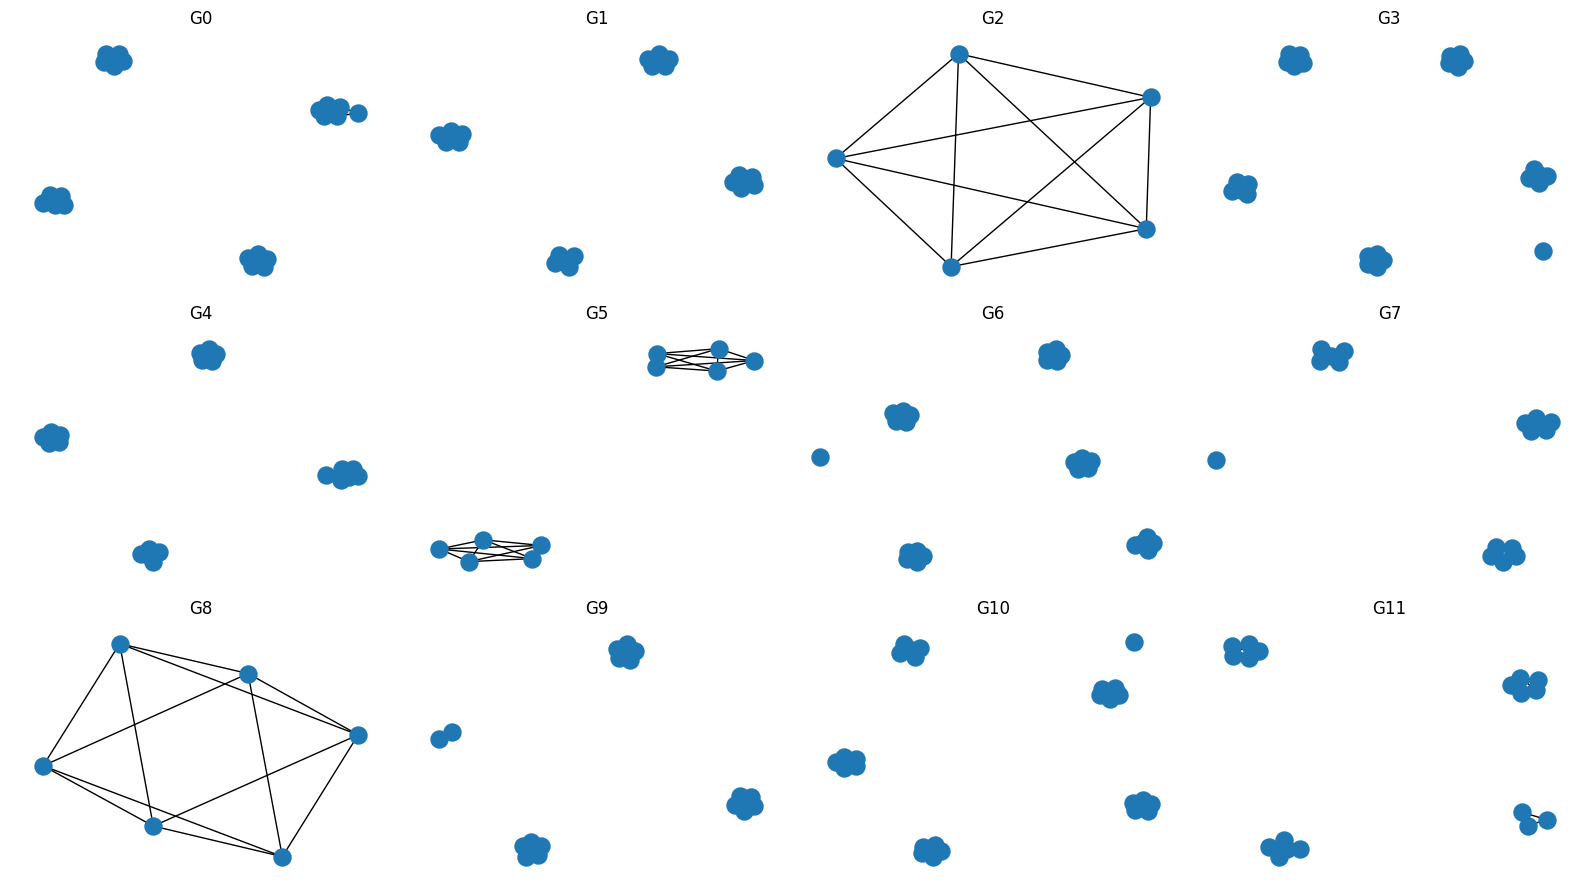

In [12]:
def _safe_hist(ax, data, bins=30, label=None, alpha=0.6):
    data = list(data) if data is not None else []
    if len(data) > 0:
        ax.hist(data, bins=bins, alpha=alpha, label=label)
    else:
        ax.plot([], [], label=label)

def compare_property_hists(gen_mols, train_set, n_train=500):
    # collect a subset of train mols for speed
    train_mols = []
    for d in train_set[:n_train]:
        m = graph_to_mol_safe(d)
        if m is None:
            continue
        try:
            Chem.SanitizeMol(m)
            train_mols.append(m)
        except Exception:
            pass

    gp = analyze_properties(gen_mols) if gen_mols else {'mw':[], 'logp':[], 'hbd':[], 'hba':[], 'tpsa':[]}
    tp = analyze_properties(train_mols) if train_mols else {'mw':[], 'logp':[], 'hbd':[], 'hba':[], 'tpsa':[]}

    names = [('mw','Molecular Weight'), ('logp','LogP'),
             ('hbd','H-bond donors'), ('hba','H-bond acceptors'), ('tpsa','TPSA')]

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
    axes = axes.flatten()

    for i, (key, title) in enumerate(names):
        ax = axes[i]
        _safe_hist(ax, tp.get(key, []), bins=30, label='Training', alpha=0.5)
        _safe_hist(ax, gp.get(key, []), bins=30, label='Generated', alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel(key.upper())
        ax.set_ylabel("Count")
        ax.grid(alpha=0.3, linestyle=':')
        ax.legend()

    if len(axes) > len(names):
        axes[-1].axis('off')

    fig.suptitle("Generated vs Training Property Distributions", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def similarity_histogram(gen_mols, train_set, n_train=500, title="Max Tanimoto similarity to training set"):
    # pool of train mols
    train_mols = []
    for d in train_set[:n_train]:
        m = graph_to_mol_safe(d)
        if m is None:
            continue
        try:
            Chem.SanitizeMol(m)
            train_mols.append(m)
        except Exception:
            pass

    if len(gen_mols) == 0 or len(train_mols) == 0:
        print("Not enough molecules to compute similarity histogram.")
        return

    gen = GetMorganGenerator(radius=2, fpSize=1024)
    fps_train = [gen.GetFingerprint(m) for m in train_mols]

    max_sims = []
    for gm in gen_mols:
        fp_g = gen.GetFingerprint(gm)
        sims = DataStructs.BulkTanimotoSimilarity(fp_g, fps_train)
        if len(sims) > 0:
            max_sims.append(max(sims))

    plt.figure(figsize=(8,5))
    _safe_hist(plt.gca(), max_sims, bins=30, label='Generated vs Train', alpha=0.7)
    plt.xlabel("Max Tanimoto Similarity")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(alpha=0.3, linestyle=':')
    plt.legend()
    plt.show()

# (Optional) quick graph-level visualization (raw graphs)
def show_raw_graphs(graphs, k=8):
    try:
        import networkx as nx
    except Exception:
        print("networkx not available; skipping raw graph plots.")
        return
    k = min(k, len(graphs))
    cols = 4
    rows = (k + cols - 1) // cols
    plt.figure(figsize=(4*cols, 3*rows))
    for i in range(k):
        g = graphs[i]
        G = nx.Graph()
        G.add_nodes_from(range(g.x.size(0)))
        if g.edge_index.numel() > 0:
            edges = g.edge_index.t().cpu().numpy().tolist()
            # undirected unique edges
            E = set()
            for u, v in edges:
                if u == v: continue
                a, b = (u, v) if u < v else (v, u)
                E.add((a, b))
            G.add_edges_from(list(E))
        plt.subplot(rows, cols, i+1)
        nx.draw(G, node_size=150)
        plt.title(f"G{i}")
    plt.tight_layout()
    plt.show()

# =========================
# 7) End-to-end: generate → evaluate → visualize
# =========================
def generate_and_evaluate(num_samples=64, max_nodes=38, T=None, topk_edges=None, seed=0,
                          train_set=None, show_grid_fig=True, show_props=True,
                          show_sim_hist=True, show_graphs=False):
    """
    Uses sample_valence_aware + labels_to_pyg, evaluates, and plots.
    Assumes globals exist: model, sched (or pass T), device, N_ATOM, ATOM_TYPES, MAX_VALENCE.
    """
    # 1) Sample with valence-aware masking
    samples = sample_valence_aware(batch_size=num_samples, max_nodes=max_nodes, T=T,
                                   topk_edges=topk_edges, seed=seed)
    # 2) Convert to PyG graphs
    graphs = labels_to_pyg(samples)
    # 3) Evaluate vs training set
    metrics, mols, smiles = evaluate_set(graphs, train_set=train_set if train_set is not None else [])
    print("Metrics:", metrics)

    # 4) Visualizations
    if show_grid_fig:
        try:
            show_mol_grid(mols, max_mols=min(50, len(mols)), title="Generated molecules (valid)")
        except Exception:
            # fallback if PIL image confuses matplotlib on some environments
            img = Draw.MolsToGridImage(mols[:min(50, len(mols))], molsPerRow=8, subImgSize=(200,200))
            plt.figure(figsize=(16,8)); plt.imshow(np.asarray(img)); plt.axis('off'); plt.title("Generated molecules (valid)"); plt.show()

    if show_props:
        if train_set is None:
            print("Pass train_set to compare_property_hists for a proper comparison.")
        else:
            compare_property_hists(mols, train_set, n_train=500)

    if show_sim_hist:
        if train_set is None:
            print("Pass train_set to similarity_histogram to compute similarities.")
        else:
            similarity_histogram(mols, train_set, n_train=500)

    if show_graphs:
        show_raw_graphs(graphs, k=min(12, len(graphs)))

    return graphs, mols, smiles, metrics

graphs, mols, smiles, metrics = generate_and_evaluate(
     num_samples=64,
     max_nodes=38,
     T=50,                 # or leave None to use sched.T
     topk_edges=200,       # optional: limit proposals per step
     seed=42,
     train_set=dataset,   # or train_ds
     show_grid_fig=True,
     show_props=True,
     show_sim_hist=True,
     show_graphs=True
)